# Notebook to Implement Model Training - LGBM

---

### Atualização sobre o status do projeto

- Foi realizada a análise exploratória com o objetivo de compreender melhor os dados que iremos trabalhar. Foram avaliados parâmetros bastante comuns de um dataset 
como quantidade de observações disponíveis, quantidade de features, tipo de cada feature (inteiro, float, categórico, string, etc), quantidade de valores zeros e NaN's 
e distribuição da variável alvo (no nosso caso 0: caso leve e 1: caso severo). Em relação a análises univariadas, foram verificadas as distribuições de variável alvo para 
cada uma das features categóricas (para buscar algum insight prévio sobre importância e poder de diferenciação das features) e, para o caso de variável de tipo inteira, 
as distribuições dos valores em relação ao tipo de caso detectado. Por fim temos uma verificação das maiores correlações entre features, o que pode ajudar na seleção de 
variáveis.

- A métrica que será adotada neste projeto será a Acurácia Balanceada (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html), 
que visa tratar melhor o caso de datasets com target desbalanceado. 

- Será utilizada a estratégia RepeatedKFold (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) com 5 folds e 10 repetições 
para o cálculo da métrica de performance em validação cruzada. A ideia é treinar e validar em diferentes folds repetidas vezes para obter um resultado estatisticamente 
mais robusto e diminuir a chance de devolver um resultado enganoso devido a uma divisão enviesada do dataset.

- Alguns experimentos que já foram realizados:

	- Utilizar o modelo LightGBM Classifier(https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) variando-se os tratamentos das 
	features e otimizando os hiper parametros utilizando o algoritmo Optuna (https://optuna.readthedocs.io/en/stable/), que é uma busca de HP baseada em otimização
	Bayesiana. Testou-se, então, treinar com as features "cruas" (sem nenhum pós processamento além dos já aplicados na obtenção das features pelo equipamento), 
	redução do espaço de features utilizando PCA, alguns algoritmos de feature scaling (MinMaxScaler, StandardScaler e RobustScaler) e, por fim, seleção de features 
	por poder preditivo utilizando o algoritmo Boruta (https://github.com/scikit-learn-contrib/boruta_py) junto com feature scaling. O melhor resultado foi obtido 
	utilizando a seleção de features via Boruta (que reduziu o espaço de features de mais de 600 para somente 29) e o scaler StandardScaler (que funciona normalizando 
	cada coluna subtraindo a média e dividindo pelo desvio padrão).

	- Os modelos encontrados através do pipeline LightGBM + Optuna + Boruta aparentam todos estarem sob regime de overfitting no conjunto de treinamento. 
	A partir dos hiper parâmetros encontrados na busca, foi realizado um esforço manual de ajuste com objetivo de reduzir o overfitting, uma espécie de fine-tuning. 
	Uma ligeira redução no overfiting foi obtida ao reduzir a complexidade do classificador e aplicar mais regularização.

	- Foi utilizado o algoritmo de redução de dimensões TSNE para visualizar os datasets estudados a partir das features selecionadas pelo Boruta. 
	É importante observar que quando são levados em conta  os dados de humanos, especialmente envolvendo fluidos biológicos, é normal que haja uma grande variação. 
	Apesar da separação alcançada não ser clara, a imagem gerada indica uma tendência, o que já é interessante para esse tipo de dado. 
	
	- Houve a tentativa de utilizar o TSNE no lugar PCA no pipeline de exploração do LightGBM + Optuna + Boruta. Foi observado que o tempo de execução do TSNE 
	aumenta de forma significativa a cada adição de uma nova dimensão, número de componentes. Foi possível testar o TSNE para o número de componentes de 2 a 18. 
	Por fim, não foi percebida nenhuma melhora performance do classificador.
	
	- Durante os experimentos, foi identificado um descolamento entre os scores de validação e teste. Era conhecido de antemão que os dados que compõe o conjunto 
	de teste haviam sido colhidos em um momento posterior aos dados de treinamento. A partir dessa informação, foi feita a suposição que motivo do descolamento 
	pudesse ser em razão um eventual data drift não identificado. Na impossibilidade adquirir mais dados, foi experimentada a geração de uma nova versão do dataset. 
	A nova versão não adiciona nenhuma amostra,  apenas reparticiona as amostras existentes de maneira estratificada com objetivo de diluir o data drift entre os 
	conjuntos de treinamento e teste. Foi observado então uma melhor acoplagem entre scores de validação e teste e uma melhoria significativa performance do modelo 
	encontrado na busca de hiper parâmetros utilizando o pipeline de otimização LightGBM+Optuna+Boruta.

### 1) Setup

In [83]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from scipy import stats
from scipy.stats import wilcoxon

from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest

import optuna
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE,KMeansSMOTE, ADASYN 

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [2]:
SEED = 42

In [3]:
TRAIN_CLINICAL_FILENAME = "train_set2.csv"
TEST_CLINICAL_FILENAME = "test_set2.csv"

---

### 2) Read and Preprocess Data

In [4]:
train = pd.read_csv(TRAIN_CLINICAL_FILENAME, sep=",")
train = train.iloc[: , 1:]

In [5]:
train.shape

(132, 547)

In [6]:
train.head()

,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,...,Freq.9059.04784969308,Freq.9098.3102509794,Freq.9436.045671808,Freq.9594.78353572215,Freq.9799.45047805923,Freq.10431.4344537929,Freq.11007.128608859,Freq.11035.3843513154,Freq.11160.836582373,Group
0,0.000251,0.000345,0.000074,3.541783e-05,0.000079,0.000245,0.000006,0.000061,0.000000e+00,0.000052,...,0.000018,0.000078,0.000070,0.000116,0.000078,0.000061,0.000102,0.000021,0.000100,MILD
1,0.000000,0.000000,0.000015,8.515219e-04,0.000107,0.001334,0.005597,0.001388,5.144433e-04,0.001511,...,0.000032,0.000004,0.000012,0.000007,0.000152,0.000008,0.000397,0.000112,0.000003,MILD
2,0.000210,0.000006,0.000018,8.649685e-09,0.000084,0.000487,0.000185,0.000092,1.294411e-04,0.000000,...,0.000119,0.000052,0.000205,0.000420,0.000060,0.000096,0.000243,0.000036,0.000253,MILD
3,0.000171,0.000233,0.000076,4.854921e-05,0.000122,0.000333,0.000038,0.000075,1.764229e-07,0.000064,...,0.000134,0.000038,0.000153,0.000124,0.000026,0.000012,0.000147,0.000052,0.000086,MILD
4,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000078,0.000074,0.000027,0.000079,0.000018,0.000044,0.000074,0.000042,0.000040,MILD


In [7]:
##### Preprocessing

train_mod = train.copy()
# Imputation using mean method
#train_mod = train_mod.replace(0,np.nan)
#train_mod_imp = train_mod.transform(lambda x: x.fillna(x.mean()))

In [8]:
train_mod.shape

(132, 547)

In [9]:
train_mod.head()

,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,...,Freq.9059.04784969308,Freq.9098.3102509794,Freq.9436.045671808,Freq.9594.78353572215,Freq.9799.45047805923,Freq.10431.4344537929,Freq.11007.128608859,Freq.11035.3843513154,Freq.11160.836582373,Group
0,0.000251,0.000345,0.000074,3.541783e-05,0.000079,0.000245,0.000006,0.000061,0.000000e+00,0.000052,...,0.000018,0.000078,0.000070,0.000116,0.000078,0.000061,0.000102,0.000021,0.000100,MILD
1,0.000000,0.000000,0.000015,8.515219e-04,0.000107,0.001334,0.005597,0.001388,5.144433e-04,0.001511,...,0.000032,0.000004,0.000012,0.000007,0.000152,0.000008,0.000397,0.000112,0.000003,MILD
2,0.000210,0.000006,0.000018,8.649685e-09,0.000084,0.000487,0.000185,0.000092,1.294411e-04,0.000000,...,0.000119,0.000052,0.000205,0.000420,0.000060,0.000096,0.000243,0.000036,0.000253,MILD
3,0.000171,0.000233,0.000076,4.854921e-05,0.000122,0.000333,0.000038,0.000075,1.764229e-07,0.000064,...,0.000134,0.000038,0.000153,0.000124,0.000026,0.000012,0.000147,0.000052,0.000086,MILD
4,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000078,0.000074,0.000027,0.000079,0.000018,0.000044,0.000074,0.000042,0.000040,MILD


In [10]:
test = pd.read_csv(TEST_CLINICAL_FILENAME, sep=",")
test = test.iloc[: , 1:]
test_mod = test.copy()
test_mod.head()

,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,...,Freq.9059.04784969308,Freq.9098.3102509794,Freq.9436.045671808,Freq.9594.78353572215,Freq.9799.45047805923,Freq.10431.4344537929,Freq.11007.128608859,Freq.11035.3843513154,Freq.11160.836582373,Group
0,1.363486e-04,0.000205,0.000115,0.000077,0.000199,0.000066,0.000024,0.000406,0.000072,0.000154,...,0.000055,0.000032,0.000028,0.000051,0.000025,0.000056,0.000083,0.000074,0.000035,MILD
1,8.938546e-07,0.000051,0.000017,0.000024,0.000017,0.000072,0.000062,0.000202,0.000217,0.000036,...,0.000026,0.000037,0.000054,0.000500,0.000125,0.000128,0.000049,0.000004,0.000192,MILD
2,2.061797e-04,0.000237,0.000002,0.000109,0.000136,0.000029,0.000629,0.000150,0.000105,0.000229,...,0.000135,0.000079,0.000053,0.000232,0.000076,0.000187,0.000120,0.000031,0.000156,MILD
3,2.256595e-03,0.001221,0.000174,0.000109,0.001292,0.000142,0.000579,0.001619,0.000003,0.002916,...,0.000016,0.000010,0.000009,0.000020,0.000030,0.000006,0.000015,0.000018,0.000021,MILD
4,1.023898e-05,0.000314,0.000073,0.000023,0.000071,0.000000,0.000430,0.000378,0.000096,0.000026,...,0.000072,0.000019,0.000072,0.000166,0.000006,0.000204,0.000079,0.000026,0.000094,MILD


In [11]:
X_test, y_test = test_mod.drop("Group", axis=1), test_mod["Group"]

---

### 3) Baseline Model Training and CV

In [44]:
# Define Classifier (or pipeline)
clf = lgb.LGBMClassifier(random_state=SEED)

In [14]:
# Get Features and Target
X, y = train_mod.drop("Group", axis=1), train_mod["Group"]

In [45]:
# Defining RepeatedKFold Cross Validator
rkf = RepeatedKFold(n_splits=5, n_repeats=20, random_state=SEED)

In [46]:
# Define metric scorer
metric_scorer = make_scorer(balanced_accuracy_score)
metric_scorer

make_scorer(balanced_accuracy_score)

In [47]:
# Cross validate model
scores = cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1)

In [48]:
# Score from each CV Iteration
scores

array([0.54605263, 0.94444444, 0.70676692, 0.61538462, 0.7797619 ,
       0.66666667, 0.875     , 0.67857143, 0.75625   , 0.83333333,
       0.64204545, 0.9       , 0.65413534, 0.81944444, 0.6875    ,
       0.80555556, 0.84117647, 0.71428571, 0.85947712, 0.71568627,
       0.725     , 0.63486842, 0.73030303, 0.66875   , 0.8875    ,
       0.76666667, 0.76923077, 0.65972222, 0.7745098 , 0.66013072,
       0.61111111, 0.73235294, 0.87593985, 0.71875   , 0.91176471,
       0.77272727, 0.66118421, 0.7202381 , 0.625     , 0.85714286,
       0.77777778, 0.875     , 0.67272727, 0.81818182, 0.69444444,
       0.89285714, 0.68181818, 0.74509804, 0.76875   , 0.89473684,
       0.84117647, 0.68333333, 0.8875    , 0.68954248, 0.65625   ,
       0.78693182, 0.76176471, 0.57638889, 0.79761905, 0.90625   ,
       0.81176471, 0.75      , 0.7202381 , 0.63194444, 0.72619048,
       0.725     , 0.8       , 0.90972222, 0.65972222, 0.73939394,
       0.84659091, 0.75      , 0.9       , 0.74183007, 0.75151

In [49]:
# Mean Metric Value
np.mean(scores)

0.7530414906515912

# Feature reduction

In [167]:
train_mod_stats = train_mod.drop('Group', axis = 1)


In [168]:
df = train_mod.copy()
peaks_list = []
pval_list = []
df2 = pd.melt(df, id_vars = ["Group"])
mild = df.where(df.Group == "MILD").dropna()
sev = df.where(df.Group == "SEVERE").dropna()
for i in range(1,(len(df.columns)-1)):
    s, p1 = stats.mannwhitneyu(mild.iloc[:,i], sev.iloc[:,i], alternative = 'two-sided')
    if p1 <= 0.05:
        pval_list.append(p1)
        peaks_list.append(df.columns[i])
peaks_list.append("Group")

In [169]:
df_filtered = df.drop(columns=[col for col in df if col not in peaks_list])
df_test_filtered = test.drop(columns=[col for col in test if col not in peaks_list])

In [170]:
df_test_filtered.shape

(64, 119)

---

In [171]:
# Get Features and Target
X, y = df_filtered.drop("Group", axis=1), df_filtered["Group"]
X_test, y_test = df_test_filtered.drop("Group", axis=1), df_test_filtered["Group"]
# Cross validate model
scores = cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1)
# Score from each CV Iteration
scores

array([0.63486842, 0.97222222, 0.70676692, 0.73076923, 0.66666667,
       0.74166667, 1.        , 0.72619048, 0.80625   , 0.83333333,
       0.6875    , 1.        , 0.77819549, 0.76388889, 0.76875   ,
       0.94444444, 0.84117647, 0.78571429, 0.85947712, 0.74509804,
       0.88333333, 0.72368421, 0.77575758, 0.81875   , 0.8875    ,
       0.84166667, 0.92307692, 0.63194444, 0.77124183, 0.63398693,
       0.69444444, 0.75294118, 0.70676692, 0.6875    , 0.88235294,
       0.83238636, 0.69736842, 0.76190476, 0.75833333, 0.92857143,
       0.77777778, 0.875     , 0.69393939, 0.83030303, 0.78472222,
       0.85714286, 0.74147727, 0.74509804, 0.8375    , 0.89473684,
       0.78235294, 0.80833333, 0.8875    , 0.74509804, 0.65625   ,
       0.81534091, 0.76176471, 0.63888889, 0.76190476, 0.96875   ,
       0.9       , 0.77777778, 0.76190476, 0.78472222, 0.76785714,
       0.69166667, 0.8       , 0.9375    , 0.75694444, 0.87575758,
       0.87784091, 0.8       , 0.7875    , 0.74183007, 0.78484

In [172]:
# Mean Metric Value
np.mean(scores)

0.7912739915743012

### 4) Experiments

##### 4.1) Hyper Parameter Optimization with Optuna

In [173]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model with param trial
    clf = lgb.LGBMClassifier(random_state=SEED, **param)
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [174]:
study = optuna.create_study(direction="maximize")

[I 2022-06-23 23:34:05,756] A new study created in memory with name: no-name-266a551f-14d7-4c9e-bae0-eb3eeb77289c


In [175]:
study.optimize(objective, n_trials=500)

[I 2022-06-23 23:34:06,946] Trial 0 finished with value: 0.5 and parameters: {'lambda_l1': 2.3595784575679856e-05, 'lambda_l2': 1.1012063752489056e-06, 'num_leaves': 184, 'feature_fraction': 0.6866384687759279, 'bagging_fraction': 0.6995098509208947, 'bagging_freq': 7, 'min_child_samples': 75, 'max_depth': 294}. Best is trial 0 with value: 0.5.
[I 2022-06-23 23:34:08,520] Trial 1 finished with value: 0.7823621184027532 and parameters: {'lambda_l1': 3.8693967443574304, 'lambda_l2': 9.689284707975446e-08, 'num_leaves': 180, 'feature_fraction': 0.8189516075958034, 'bagging_fraction': 0.9077794004028834, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 906}. Best is trial 1 with value: 0.7823621184027532.
[I 2022-06-23 23:34:09,175] Trial 2 finished with value: 0.5 and parameters: {'lambda_l1': 0.04583950873771014, 'lambda_l2': 0.030289944481967472, 'num_leaves': 158, 'feature_fraction': 0.4396819945927838, 'bagging_fraction': 0.6935136647082449, 'bagging_freq': 6, 'min_child_sampl

[I 2022-06-23 23:34:32,041] Trial 22 finished with value: 0.8458864038653124 and parameters: {'lambda_l1': 0.0049848585689571435, 'lambda_l2': 0.4350407031813399, 'num_leaves': 190, 'feature_fraction': 0.40232254850151916, 'bagging_fraction': 0.7686444240928251, 'bagging_freq': 5, 'min_child_samples': 20, 'max_depth': 191}. Best is trial 20 with value: 0.8514517096680408.
[I 2022-06-23 23:34:32,944] Trial 23 finished with value: 0.8483214730960473 and parameters: {'lambda_l1': 0.00014041839015897656, 'lambda_l2': 0.024737071573333977, 'num_leaves': 141, 'feature_fraction': 0.5309675943408307, 'bagging_fraction': 0.6007980823669852, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 324}. Best is trial 20 with value: 0.8514517096680408.
[I 2022-06-23 23:34:34,448] Trial 24 finished with value: 0.8261507213546686 and parameters: {'lambda_l1': 0.3387155633074678, 'lambda_l2': 0.00013554409961060858, 'num_leaves': 103, 'feature_fraction': 0.5148044341195899, 'bagging_fraction': 0.828

[I 2022-06-23 23:34:56,458] Trial 44 finished with value: 0.8309216784462528 and parameters: {'lambda_l1': 0.12805272165280263, 'lambda_l2': 1.1096030783653459e-08, 'num_leaves': 146, 'feature_fraction': 0.564379479523821, 'bagging_fraction': 0.4740626746323659, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 160}. Best is trial 34 with value: 0.8587185535482749.
[I 2022-06-23 23:34:58,260] Trial 45 finished with value: 0.847702398521671 and parameters: {'lambda_l1': 0.0042033404046229175, 'lambda_l2': 3.45172810622433e-08, 'num_leaves': 82, 'feature_fraction': 0.5986836272784102, 'bagging_fraction': 0.5004357529230422, 'bagging_freq': 3, 'min_child_samples': 7, 'max_depth': 295}. Best is trial 34 with value: 0.8587185535482749.
[I 2022-06-23 23:34:59,397] Trial 46 finished with value: 0.8450055008416075 and parameters: {'lambda_l1': 0.6769662413006188, 'lambda_l2': 1.2202155135645877e-07, 'num_leaves': 128, 'feature_fraction': 0.6577406849774157, 'bagging_fraction': 0.4587901

[I 2022-06-23 23:35:23,777] Trial 66 finished with value: 0.8624388564222155 and parameters: {'lambda_l1': 3.332194359867164e-08, 'lambda_l2': 2.8748091577579024e-07, 'num_leaves': 99, 'feature_fraction': 0.5202959488420069, 'bagging_fraction': 0.6412478137487818, 'bagging_freq': 4, 'min_child_samples': 31, 'max_depth': 890}. Best is trial 62 with value: 0.8627685659283957.
[I 2022-06-23 23:35:25,717] Trial 67 finished with value: 0.8590302445018003 and parameters: {'lambda_l1': 6.486994021115984e-08, 'lambda_l2': 3.3498734276185855e-07, 'num_leaves': 80, 'feature_fraction': 0.5212812170695712, 'bagging_fraction': 0.6395867937595023, 'bagging_freq': 4, 'min_child_samples': 18, 'max_depth': 875}. Best is trial 62 with value: 0.8627685659283957.
[I 2022-06-23 23:35:27,604] Trial 68 finished with value: 0.861898707029125 and parameters: {'lambda_l1': 4.5346043038858475e-08, 'lambda_l2': 2.3372156525239048e-07, 'num_leaves': 71, 'feature_fraction': 0.5274956655946123, 'bagging_fraction': 0

[I 2022-06-23 23:36:01,954] Trial 88 finished with value: 0.8526266152578073 and parameters: {'lambda_l1': 4.818120766385874e-08, 'lambda_l2': 1.2497593771243688e-05, 'num_leaves': 47, 'feature_fraction': 0.48639136083604334, 'bagging_fraction': 0.555751654860862, 'bagging_freq': 4, 'min_child_samples': 32, 'max_depth': 914}. Best is trial 62 with value: 0.8627685659283957.
[I 2022-06-23 23:36:02,743] Trial 89 finished with value: 0.5 and parameters: {'lambda_l1': 1.600771207270657e-08, 'lambda_l2': 2.466229149104665e-06, 'num_leaves': 102, 'feature_fraction': 0.5074234648852856, 'bagging_fraction': 0.7060544958260057, 'bagging_freq': 3, 'min_child_samples': 51, 'max_depth': 745}. Best is trial 62 with value: 0.8627685659283957.
[I 2022-06-23 23:36:03,568] Trial 90 finished with value: 0.652139272814389 and parameters: {'lambda_l1': 0.0007686671648022217, 'lambda_l2': 5.509232029833948e-06, 'num_leaves': 21, 'feature_fraction': 0.4410034475085249, 'bagging_fraction': 0.6756921246120623

[I 2022-06-23 23:36:35,669] Trial 110 finished with value: 0.8507242804495126 and parameters: {'lambda_l1': 1.0159467181529021e-05, 'lambda_l2': 6.213213697908753e-08, 'num_leaves': 119, 'feature_fraction': 0.5973770740931523, 'bagging_fraction': 0.5564618457768707, 'bagging_freq': 7, 'min_child_samples': 16, 'max_depth': 811}. Best is trial 93 with value: 0.8669831659783285.
[I 2022-06-23 23:36:37,271] Trial 111 finished with value: 0.8632371132049924 and parameters: {'lambda_l1': 4.95036111816296e-07, 'lambda_l2': 5.77697730476053e-07, 'num_leaves': 115, 'feature_fraction': 0.5596063700980043, 'bagging_fraction': 0.514225138782351, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 675}. Best is trial 93 with value: 0.8669831659783285.
[I 2022-06-23 23:36:39,441] Trial 112 finished with value: 0.8613373396684154 and parameters: {'lambda_l1': 1.0505812770458955e-06, 'lambda_l2': 5.433539435674912e-07, 'num_leaves': 109, 'feature_fraction': 0.5551352574660887, 'bagging_fraction':

[I 2022-06-23 23:37:14,648] Trial 131 finished with value: 0.8612691074620252 and parameters: {'lambda_l1': 1.4447298520837669e-06, 'lambda_l2': 3.972040831436347e-07, 'num_leaves': 107, 'feature_fraction': 0.5090066986371035, 'bagging_fraction': 0.5617362531838136, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 879}. Best is trial 93 with value: 0.8669831659783285.
[I 2022-06-23 23:37:16,561] Trial 132 finished with value: 0.8642255075720634 and parameters: {'lambda_l1': 3.639981739520953e-05, 'lambda_l2': 1.6309334424409136e-07, 'num_leaves': 77, 'feature_fraction': 0.5447445262144984, 'bagging_fraction': 0.5257647253495119, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 912}. Best is trial 93 with value: 0.8669831659783285.
[I 2022-06-23 23:37:17,967] Trial 133 finished with value: 0.861188004934522 and parameters: {'lambda_l1': 3.0364323160031347e-05, 'lambda_l2': 1.646446088067987e-07, 'num_leaves': 45, 'feature_fraction': 0.4057581295612533, 'bagging_fraction'

[I 2022-06-23 23:37:56,341] Trial 153 finished with value: 0.8527526709831276 and parameters: {'lambda_l1': 6.160326146954555e-05, 'lambda_l2': 9.683751181348257e-07, 'num_leaves': 52, 'feature_fraction': 0.4771417795844353, 'bagging_fraction': 0.5874330405425392, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 788}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:37:58,443] Trial 154 finished with value: 0.859382634865994 and parameters: {'lambda_l1': 3.280300841432966e-05, 'lambda_l2': 1.3801506762654663e-07, 'num_leaves': 62, 'feature_fraction': 0.46065415840021795, 'bagging_fraction': 0.4942941749492299, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 909}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:38:00,711] Trial 155 finished with value: 0.8602038302040236 and parameters: {'lambda_l1': 0.0001390538871014217, 'lambda_l2': 3.0694065297350307e-07, 'num_leaves': 74, 'feature_fraction': 0.7998937463086497, 'bagging_fraction':

[I 2022-06-23 23:38:33,121] Trial 174 finished with value: 0.8644614868705426 and parameters: {'lambda_l1': 1.992813575788047e-05, 'lambda_l2': 2.9737669071130354e-08, 'num_leaves': 43, 'feature_fraction': 0.4181771462743229, 'bagging_fraction': 0.5632852406039218, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 849}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:38:35,083] Trial 175 finished with value: 0.8605554749043526 and parameters: {'lambda_l1': 5.313869915439392e-05, 'lambda_l2': 7.644804592458342e-08, 'num_leaves': 39, 'feature_fraction': 0.41610508633309434, 'bagging_fraction': 0.5673298232976314, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 847}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:38:37,219] Trial 176 finished with value: 0.8590831013456787 and parameters: {'lambda_l1': 3.1573112506855846e-05, 'lambda_l2': 3.491879012284155e-07, 'num_leaves': 45, 'feature_fraction': 0.5174036732496221, 'bagging_fraction'

[I 2022-06-23 23:39:11,767] Trial 195 finished with value: 0.8598642040578958 and parameters: {'lambda_l1': 2.9885149481594142e-05, 'lambda_l2': 4.916188634469289e-07, 'num_leaves': 231, 'feature_fraction': 0.8987861013454304, 'bagging_fraction': 0.5746642052695575, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 766}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:39:13,581] Trial 196 finished with value: 0.8627065093059673 and parameters: {'lambda_l1': 1.1386823416540284e-06, 'lambda_l2': 2.2451851361478862e-07, 'num_leaves': 91, 'feature_fraction': 0.47656871975998566, 'bagging_fraction': 0.5123133660949802, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 820}. Best is trial 139 with value: 0.867258153868835.
[I 2022-06-23 23:39:14,822] Trial 197 finished with value: 0.8569075719172469 and parameters: {'lambda_l1': 4.693603665232704e-06, 'lambda_l2': 3.6213107143618475e-07, 'num_leaves': 47, 'feature_fraction': 0.4481619445395129, 'bagging_fracti

[I 2022-06-23 23:39:53,252] Trial 217 finished with value: 0.8687246830182201 and parameters: {'lambda_l1': 0.0012186619598463103, 'lambda_l2': 0.010621422784060185, 'num_leaves': 91, 'feature_fraction': 0.41026908475219803, 'bagging_fraction': 0.538812846851669, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 846}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:39:55,171] Trial 218 finished with value: 0.8604815054441601 and parameters: {'lambda_l1': 0.006115342657051539, 'lambda_l2': 0.032586685379544005, 'num_leaves': 93, 'feature_fraction': 0.4004934751756876, 'bagging_fraction': 0.5425119414960488, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 847}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:39:57,393] Trial 219 finished with value: 0.8633436895277065 and parameters: {'lambda_l1': 0.002099628661688207, 'lambda_l2': 0.012878897352011542, 'num_leaves': 99, 'feature_fraction': 0.42121939158656935, 'bagging_fraction': 0.5

[I 2022-06-23 23:40:40,244] Trial 239 finished with value: 0.8570742702215225 and parameters: {'lambda_l1': 0.003407753744998582, 'lambda_l2': 0.0004829150728734601, 'num_leaves': 74, 'feature_fraction': 0.41271730742862905, 'bagging_fraction': 0.5834663545190748, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 829}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:40:42,509] Trial 240 finished with value: 0.8578470547340515 and parameters: {'lambda_l1': 0.0018567023036396508, 'lambda_l2': 0.006783336498717448, 'num_leaves': 72, 'feature_fraction': 0.4359513805905052, 'bagging_fraction': 0.5932072573261093, 'bagging_freq': 7, 'min_child_samples': 19, 'max_depth': 869}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:40:44,549] Trial 241 finished with value: 0.8648182820361613 and parameters: {'lambda_l1': 0.0008996885138093709, 'lambda_l2': 0.00402858107500018, 'num_leaves': 82, 'feature_fraction': 0.400235073982503, 'bagging_fraction': 0.5

[I 2022-06-23 23:41:22,642] Trial 261 finished with value: 0.8606191635377006 and parameters: {'lambda_l1': 0.00019073427580550075, 'lambda_l2': 0.056330374846064714, 'num_leaves': 85, 'feature_fraction': 0.41881802125967516, 'bagging_fraction': 0.5485985929754897, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 755}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:41:24,768] Trial 262 finished with value: 0.8543616865375765 and parameters: {'lambda_l1': 0.0020098973369900163, 'lambda_l2': 0.00012110619127255987, 'num_leaves': 89, 'feature_fraction': 0.5543993402685228, 'bagging_fraction': 0.5722723820344939, 'bagging_freq': 7, 'min_child_samples': 17, 'max_depth': 840}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:41:26,531] Trial 263 finished with value: 0.8612881434655815 and parameters: {'lambda_l1': 0.0006064282363193419, 'lambda_l2': 0.006422929091744252, 'num_leaves': 73, 'feature_fraction': 0.45047473547357564, 'bagging_fraction

[I 2022-06-23 23:42:01,687] Trial 282 finished with value: 0.862293431392309 and parameters: {'lambda_l1': 0.0003222299057201958, 'lambda_l2': 0.009968675665249609, 'num_leaves': 125, 'feature_fraction': 0.4525041252483267, 'bagging_fraction': 0.5303749787214656, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 733}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:42:03,887] Trial 283 finished with value: 0.8535479988922325 and parameters: {'lambda_l1': 0.010161786385994208, 'lambda_l2': 0.023821569762222806, 'num_leaves': 78, 'feature_fraction': 0.6633804834656041, 'bagging_fraction': 0.5372874500773479, 'bagging_freq': 7, 'min_child_samples': 15, 'max_depth': 772}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:42:05,484] Trial 284 finished with value: 0.8626389157368258 and parameters: {'lambda_l1': 0.002347697085999192, 'lambda_l2': 0.01020009205122552, 'num_leaves': 87, 'feature_fraction': 0.46222371305536974, 'bagging_fraction': 0.49

[I 2022-06-23 23:42:38,175] Trial 304 finished with value: 0.8602551586914977 and parameters: {'lambda_l1': 0.0015497999131978209, 'lambda_l2': 0.005108269337080783, 'num_leaves': 73, 'feature_fraction': 0.4852500586431378, 'bagging_fraction': 0.49651833170337667, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 917}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:42:40,307] Trial 305 finished with value: 0.8622846610518823 and parameters: {'lambda_l1': 0.0005859550425546332, 'lambda_l2': 0.012318197143969744, 'num_leaves': 101, 'feature_fraction': 0.5059871424473631, 'bagging_fraction': 0.56020503402158, 'bagging_freq': 7, 'min_child_samples': 21, 'max_depth': 974}. Best is trial 217 with value: 0.8687246830182201.
[I 2022-06-23 23:42:42,045] Trial 306 finished with value: 0.8633898118994867 and parameters: {'lambda_l1': 9.241020663959357e-08, 'lambda_l2': 0.07522733004311231, 'num_leaves': 154, 'feature_fraction': 0.5368488784201112, 'bagging_fraction': 0.

[I 2022-06-23 23:43:23,234] Trial 325 finished with value: 0.8578223068211457 and parameters: {'lambda_l1': 0.00025096486808194596, 'lambda_l2': 0.001570835679880564, 'num_leaves': 85, 'feature_fraction': 0.7794277181682177, 'bagging_fraction': 0.5488731257982931, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 806}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:43:25,317] Trial 326 finished with value: 0.8588471341180319 and parameters: {'lambda_l1': 0.0003103410687211104, 'lambda_l2': 7.505080496073651e-08, 'num_leaves': 136, 'feature_fraction': 0.4210518289704224, 'bagging_fraction': 0.5743215995516393, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 859}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:43:27,605] Trial 327 finished with value: 0.8621488113924258 and parameters: {'lambda_l1': 0.0004551025855082303, 'lambda_l2': 0.003075894258533625, 'num_leaves': 110, 'feature_fraction': 0.9205295784603666, 'bagging_fraction'

[I 2022-06-23 23:44:04,883] Trial 347 finished with value: 0.8481726023374629 and parameters: {'lambda_l1': 0.630887588496574, 'lambda_l2': 6.003688132312409e-08, 'num_leaves': 195, 'feature_fraction': 0.5353282323522818, 'bagging_fraction': 0.556684312534875, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 522}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:44:06,769] Trial 348 finished with value: 0.8666485605253019 and parameters: {'lambda_l1': 5.218685746662984e-07, 'lambda_l2': 0.014915915120576504, 'num_leaves': 149, 'feature_fraction': 0.5761036132554095, 'bagging_fraction': 0.5220605779995002, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 838}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:44:08,157] Trial 349 finished with value: 0.8496795661983357 and parameters: {'lambda_l1': 4.2357057267967383e-07, 'lambda_l2': 0.00017216070444441708, 'num_leaves': 190, 'feature_fraction': 0.5776818728179284, 'bagging_fraction': 

[I 2022-06-23 23:44:48,463] Trial 369 finished with value: 0.8638034359860985 and parameters: {'lambda_l1': 5.441755742344828e-07, 'lambda_l2': 0.1826744513897969, 'num_leaves': 209, 'feature_fraction': 0.42453658394820515, 'bagging_fraction': 0.5349531027865656, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 924}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:44:49,812] Trial 370 finished with value: 0.8594715465562989 and parameters: {'lambda_l1': 0.013642825056322413, 'lambda_l2': 0.00623738419612872, 'num_leaves': 147, 'feature_fraction': 0.5114270979783081, 'bagging_fraction': 0.5451786034181727, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 549}. Best is trial 314 with value: 0.8692806059609466.
[I 2022-06-23 23:44:51,642] Trial 371 finished with value: 0.8580650440890377 and parameters: {'lambda_l1': 0.0009473148386408692, 'lambda_l2': 4.978059548390485e-08, 'num_leaves': 253, 'feature_fraction': 0.5444208769024191, 'bagging_fraction': 0

[I 2022-06-23 23:45:23,762] Trial 390 finished with value: 0.8326813908915303 and parameters: {'lambda_l1': 1.406645375598954e-06, 'lambda_l2': 3.3818791600288737e-07, 'num_leaves': 143, 'feature_fraction': 0.47387325973299066, 'bagging_fraction': 0.5115302451331699, 'bagging_freq': 7, 'min_child_samples': 32, 'max_depth': 993}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:45:26,080] Trial 391 finished with value: 0.867966289451003 and parameters: {'lambda_l1': 3.6055919093473432e-06, 'lambda_l2': 3.234812940229759e-07, 'num_leaves': 148, 'feature_fraction': 0.4615413056785933, 'bagging_fraction': 0.5220472425680726, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 977}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:45:28,311] Trial 392 finished with value: 0.8669040362587189 and parameters: {'lambda_l1': 8.88292186759587e-07, 'lambda_l2': 3.328163649830276e-07, 'num_leaves': 144, 'feature_fraction': 0.47698257271973377, 'bagging_fract

[I 2022-06-23 23:46:01,082] Trial 411 finished with value: 0.8621527785295199 and parameters: {'lambda_l1': 7.862166665867306e-07, 'lambda_l2': 9.375295112829582e-07, 'num_leaves': 149, 'feature_fraction': 0.5195885221499709, 'bagging_fraction': 0.5074669680301662, 'bagging_freq': 7, 'min_child_samples': 24, 'max_depth': 1000}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:46:03,744] Trial 412 finished with value: 0.8485060990136453 and parameters: {'lambda_l1': 4.4308282282747516e-07, 'lambda_l2': 1.2717635615583436e-07, 'num_leaves': 185, 'feature_fraction': 0.5131652890535878, 'bagging_fraction': 0.8314598201254372, 'bagging_freq': 7, 'min_child_samples': 25, 'max_depth': 955}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:46:06,098] Trial 413 finished with value: 0.8655736146378561 and parameters: {'lambda_l1': 1.2132822998094689e-06, 'lambda_l2': 1.972375816184608e-06, 'num_leaves': 152, 'feature_fraction': 0.539245041044746, 'bagging_frac

[I 2022-06-23 23:46:42,814] Trial 432 finished with value: 0.8587951116006457 and parameters: {'lambda_l1': 1.4618734850486864e-06, 'lambda_l2': 2.785306771823844e-07, 'num_leaves': 203, 'feature_fraction': 0.4398351627047236, 'bagging_fraction': 0.5587211703943287, 'bagging_freq': 7, 'min_child_samples': 30, 'max_depth': 885}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:46:45,113] Trial 433 finished with value: 0.85830191340737 and parameters: {'lambda_l1': 2.51236434437743e-07, 'lambda_l2': 1.8500154137947161e-07, 'num_leaves': 124, 'feature_fraction': 0.4258237180209296, 'bagging_fraction': 0.5485874266513936, 'bagging_freq': 3, 'min_child_samples': 27, 'max_depth': 999}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:46:45,677] Trial 434 finished with value: 0.5 and parameters: {'lambda_l1': 1.0636700836231468e-06, 'lambda_l2': 4.381405214615813e-07, 'num_leaves': 17, 'feature_fraction': 0.7342794959526207, 'bagging_fraction': 0.5269836892

[I 2022-06-23 23:47:33,652] Trial 454 finished with value: 0.8635215630602627 and parameters: {'lambda_l1': 4.3002192248139256e-07, 'lambda_l2': 0.028597780748577294, 'num_leaves': 110, 'feature_fraction': 0.48550049305664245, 'bagging_fraction': 0.525828965467082, 'bagging_freq': 7, 'min_child_samples': 28, 'max_depth': 956}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:47:36,845] Trial 455 finished with value: 0.8533881371251725 and parameters: {'lambda_l1': 6.370676102521838e-08, 'lambda_l2': 0.027683053584809363, 'num_leaves': 98, 'feature_fraction': 0.44052853721318935, 'bagging_fraction': 0.7429723414731342, 'bagging_freq': 7, 'min_child_samples': 23, 'max_depth': 977}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:47:39,288] Trial 456 finished with value: 0.8604125516511353 and parameters: {'lambda_l1': 9.679893940325626e-07, 'lambda_l2': 0.0798298504459157, 'num_leaves': 128, 'feature_fraction': 0.46269500166706584, 'bagging_fraction':

[I 2022-06-23 23:48:21,140] Trial 475 finished with value: 0.8584953768926291 and parameters: {'lambda_l1': 2.4852837200631695e-07, 'lambda_l2': 2.3422306931688404e-06, 'num_leaves': 90, 'feature_fraction': 0.41176162863497945, 'bagging_fraction': 0.5597154304705471, 'bagging_freq': 6, 'min_child_samples': 22, 'max_depth': 850}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:48:23,256] Trial 476 finished with value: 0.8573552238310365 and parameters: {'lambda_l1': 6.555638964960354e-07, 'lambda_l2': 3.945930538524973e-06, 'num_leaves': 95, 'feature_fraction': 0.42314432709406696, 'bagging_fraction': 0.5729497265985805, 'bagging_freq': 7, 'min_child_samples': 18, 'max_depth': 801}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:48:25,359] Trial 477 finished with value: 0.8652563879404049 and parameters: {'lambda_l1': 8.007413607892195e-07, 'lambda_l2': 8.305079310786386e-07, 'num_leaves': 106, 'feature_fraction': 0.43352943884006595, 'bagging_frac

[I 2022-06-23 23:49:05,827] Trial 496 finished with value: 0.8651252549050535 and parameters: {'lambda_l1': 0.00021724973622386085, 'lambda_l2': 3.213181290608168e-07, 'num_leaves': 89, 'feature_fraction': 0.43212384421408406, 'bagging_fraction': 0.5437777658203073, 'bagging_freq': 7, 'min_child_samples': 29, 'max_depth': 766}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:49:08,503] Trial 497 finished with value: 0.8631671972248597 and parameters: {'lambda_l1': 0.00936132840023022, 'lambda_l2': 1.9074403363786395e-07, 'num_leaves': 148, 'feature_fraction': 0.46194213370316994, 'bagging_fraction': 0.5589369795428327, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 848}. Best is trial 389 with value: 0.8707509203687609.
[I 2022-06-23 23:49:09,761] Trial 498 finished with value: 0.6010329444162649 and parameters: {'lambda_l1': 4.6622755268778554e-07, 'lambda_l2': 1.0941142690987427e-06, 'num_leaves': 105, 'feature_fraction': 0.4952329137180995, 'bagging_frac

In [176]:
# Get best trial based on metric score
trial = study.best_trial

In [177]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    lambda_l1: 1.2537265730755262e-06
    lambda_l2: 3.451074192111965e-07
    num_leaves: 141
    feature_fraction: 0.4703062413129908
    bagging_fraction: 0.5227902554474249
    bagging_freq: 7
    min_child_samples: 27
    max_depth: 996


In [178]:
# Best Score from HP Opt
trial.values[0]

0.8707509203687609

- Aumento de performance considerável em relação ao valor baseline para um LGBM

##### 4.2) PCA Dimension Reduction + Hyper Parameter Optimization with Optuna

In [181]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # PCA Parameter Grid
    pca_param = {
        "n_components": trial.suggest_int("n_components", 5, 100)
    }
    # Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("pca", PCA(**pca_param)),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [182]:
study = optuna.create_study(direction="maximize")

[I 2022-06-17 15:30:06,080] A new study created in memory with name: no-name-adfd880b-812e-41f4-828a-f1b968db75c6


In [ ]:
study.optimize(objective, n_trials=500)

In [26]:
# Get best trial based on metric score
trial = study.best_trial

In [27]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    n_components: 98
    lambda_l1: 4.997984938308335e-06
    lambda_l2: 9.51579276153768e-06
    num_leaves: 44
    feature_fraction: 0.5421454819677247
    bagging_fraction: 0.48235662397332973
    bagging_freq: 4
    min_child_samples: 8
    max_depth: 563


In [28]:
# Best Score from HP Opt
trial.values[0]

0.7134464057614213

- Utilizar redução de dimensionalidade via PCA piorou bastante a performance do modelo

##### 4.3) Features Scaler + Hyper Parameter Optimization with Optuna

In [29]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [30]:
study = optuna.create_study(direction="maximize")

[I 2022-06-07 22:15:09,043] A new study created in memory with name: no-name-9d027bd4-11fc-4b2d-8846-da6f6ffb30f6


In [ ]:
study.optimize(objective, n_trials=500)

In [32]:
# Get best trial based on metric score
trial = study.best_trial

In [33]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: robust
    lambda_l1: 4.3223282482835764e-07
    lambda_l2: 3.3796186878776776e-05
    num_leaves: 188
    feature_fraction: 0.650978565866076
    bagging_fraction: 0.9212536490874126
    bagging_freq: 7
    min_child_samples: 36
    max_depth: 956


In [34]:
# Best Score from HP Opt
trial.values[0]

0.8521054248039541

- A adição de um estágio de feature scaling antes do treinamento parece ter ajudado o modelo

##### 4.4) Boruta Feature Selection + Features Scaler + Hyper Parameter Optimization with Optuna

In [217]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )

In [218]:
feat_selector.fit(np.array(X), y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	476
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	16 / 100
Confirmed: 	2

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=193, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1BC734BF140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1BC734BF140, verbose=2)

In [219]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  33


In [220]:
# Best Features (accord to Boruta)
X.columns[feat_selector.support_]

Index(['Freq.1399.46591504505', 'Freq.1522.99914751846',
       'Freq.1715.83254187774', 'Freq.1740.12061901788',
       'Freq.1794.21713030157', 'Freq.2032.98713905056',
       'Freq.2100.44990262345', 'Freq.2182.54012190969',
       'Freq.2187.26929655148', 'Freq.2241.01398322552',
       'Freq.2461.57721259156', 'Freq.2822.17822957638',
       'Freq.2981.05105455515', 'Freq.3083.87231952593',
       'Freq.3795.45160708473', 'Freq.3983.61553339652',
       'Freq.4266.97846896688', 'Freq.4283.95182164633',
       'Freq.4307.03317519015', 'Freq.4395.11277752994',
       'Freq.4495.09063766933', 'Freq.4659.55667096198',
       'Freq.4802.98802524845', 'Freq.4823.08140765752',
       'Freq.5084.14952111257', 'Freq.5224.84719303067',
       'Freq.5272.6322523475', 'Freq.5433.53206707083',
       'Freq.5485.69282171011', 'Freq.5720.79450801948',
       'Freq.7738.2889532685', 'Freq.8943.8000787644', 'Freq.9098.3102509794'],
      dtype='object')

In [221]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X))

In [222]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform, y, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [223]:
study = optuna.create_study(direction="maximize")

[I 2022-06-24 00:05:09,001] A new study created in memory with name: no-name-7e03f0db-a45d-43fa-aeb6-3eaeb5815ff6


In [224]:
study.optimize(objective, n_trials=500)

[I 2022-06-24 00:07:07,780] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 1.736164714022951e-05, 'lambda_l2': 0.0008744806520391302, 'num_leaves': 186, 'feature_fraction': 0.8593730467230957, 'bagging_fraction': 0.7039252573471362, 'bagging_freq': 5, 'min_child_samples': 67, 'max_depth': 291}. Best is trial 0 with value: 0.5.
[I 2022-06-24 00:07:08,583] Trial 1 finished with value: 0.8603665093506424 and parameters: {'scalers': 'standard', 'lambda_l1': 0.008622697977459544, 'lambda_l2': 6.208314622454566e-08, 'num_leaves': 184, 'feature_fraction': 0.701051773780067, 'bagging_fraction': 0.4008763757819356, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 476}. Best is trial 1 with value: 0.8603665093506424.
[I 2022-06-24 00:07:09,649] Trial 2 finished with value: 0.8380926025728658 and parameters: {'scalers': 'robust', 'lambda_l1': 0.17266781673396256, 'lambda_l2': 1.059988995841295e-07, 'num_leaves': 30, 'feature_fraction': 0.478233073255

[I 2022-06-24 00:07:27,143] Trial 21 finished with value: 0.8489316654063171 and parameters: {'scalers': 'standard', 'lambda_l1': 1.402975481383046e-08, 'lambda_l2': 9.991701764028775e-05, 'num_leaves': 225, 'feature_fraction': 0.9238790545409372, 'bagging_fraction': 0.47278969400458437, 'bagging_freq': 3, 'min_child_samples': 18, 'max_depth': 562}. Best is trial 18 with value: 0.8606703089007656.
[I 2022-06-24 00:07:28,404] Trial 22 finished with value: 0.8557324019289964 and parameters: {'scalers': 'standard', 'lambda_l1': 1.9395373152078576e-07, 'lambda_l2': 2.458075416311321e-07, 'num_leaves': 227, 'feature_fraction': 0.9393163921111374, 'bagging_fraction': 0.45858041879466954, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 556}. Best is trial 18 with value: 0.8606703089007656.
[I 2022-06-24 00:07:29,803] Trial 23 finished with value: 0.8553611502231858 and parameters: {'scalers': 'standard', 'lambda_l1': 1.023051122687271e-07, 'lambda_l2': 2.0728780087572496e-05, 'num_le

[I 2022-06-24 00:07:43,881] Trial 42 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 4.016506692881616e-08, 'lambda_l2': 8.445820809561303e-06, 'num_leaves': 159, 'feature_fraction': 0.9554397718072419, 'bagging_fraction': 0.7313497446825487, 'bagging_freq': 1, 'min_child_samples': 46, 'max_depth': 401}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:07:44,462] Trial 43 finished with value: 0.8532307688656373 and parameters: {'scalers': 'robust', 'lambda_l1': 3.3006575930054615e-07, 'lambda_l2': 4.0587916862520554e-05, 'num_leaves': 144, 'feature_fraction': 0.8524526137899114, 'bagging_fraction': 0.6827111778722371, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 138}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:07:45,844] Trial 44 finished with value: 0.8565074724252356 and parameters: {'scalers': 'robust', 'lambda_l1': 1.718341135731164e-08, 'lambda_l2': 1.010455807137174e-06, 'num_leaves': 85, 'feature_fract

[I 2022-06-24 00:08:01,232] Trial 63 finished with value: 0.8597860226074237 and parameters: {'scalers': 'standard', 'lambda_l1': 2.640054204056451e-08, 'lambda_l2': 2.10337760151054e-08, 'num_leaves': 184, 'feature_fraction': 0.7129508948932183, 'bagging_fraction': 0.4052925742915207, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 665}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:01,819] Trial 64 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 5.72724282074693e-08, 'lambda_l2': 1.6165174186927202e-07, 'num_leaves': 157, 'feature_fraction': 0.7290473533412141, 'bagging_fraction': 0.4385790711428784, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 750}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:02,303] Trial 65 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 2.358237908871582e-08, 'lambda_l2': 3.9888316362284076e-07, 'num_leaves': 142, 'feature_fraction': 0.76

[I 2022-06-24 00:08:18,053] Trial 84 finished with value: 0.8640526208182941 and parameters: {'scalers': 'robust', 'lambda_l1': 8.569444484836788e-08, 'lambda_l2': 0.003779939269437846, 'num_leaves': 175, 'feature_fraction': 0.48316712380251475, 'bagging_fraction': 0.5208280746556682, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 309}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:18,612] Trial 85 finished with value: 0.7416672635500035 and parameters: {'scalers': 'robust', 'lambda_l1': 1.5643004554794204e-08, 'lambda_l2': 0.001078940432489709, 'num_leaves': 176, 'feature_fraction': 0.9055578204624273, 'bagging_fraction': 0.40177537631439764, 'bagging_freq': 1, 'min_child_samples': 26, 'max_depth': 311}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:19,400] Trial 86 finished with value: 0.8526485367702473 and parameters: {'scalers': 'robust', 'lambda_l1': 4.340889648922245e-08, 'lambda_l2': 0.0516618407255378, 'num_leaves': 170, 'f

[I 2022-06-24 00:08:38,348] Trial 105 finished with value: 0.8575949885812502 and parameters: {'scalers': 'robust', 'lambda_l1': 6.143209318456959e-08, 'lambda_l2': 0.023437625666072194, 'num_leaves': 123, 'feature_fraction': 0.8342478263367732, 'bagging_fraction': 0.4031627616780694, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 225}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:39,315] Trial 106 finished with value: 0.8489890327680576 and parameters: {'scalers': 'robust', 'lambda_l1': 1.0030812723247223e-08, 'lambda_l2': 0.0053953079813989545, 'num_leaves': 114, 'feature_fraction': 0.7877723157014915, 'bagging_fraction': 0.6931044440652246, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 163}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:08:40,201] Trial 107 finished with value: 0.8627445574506332 and parameters: {'scalers': 'robust', 'lambda_l1': 3.112841148044115e-08, 'lambda_l2': 0.0006935170761408872, 'num_leaves': 14

[I 2022-06-24 00:08:59,205] Trial 126 finished with value: 0.8629881753523395 and parameters: {'scalers': 'robust', 'lambda_l1': 8.643101790839507e-08, 'lambda_l2': 2.2214959529008746, 'num_leaves': 105, 'feature_fraction': 0.90879926145945, 'bagging_fraction': 0.5139137783824822, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 273}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:00,511] Trial 127 finished with value: 0.8615623654596177 and parameters: {'scalers': 'robust', 'lambda_l1': 2.2011745070006225e-07, 'lambda_l2': 6.220165955241483, 'num_leaves': 93, 'feature_fraction': 0.897997434720152, 'bagging_fraction': 0.45311565439632295, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 374}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:01,282] Trial 128 finished with value: 0.8196744114588544 and parameters: {'scalers': 'robust', 'lambda_l1': 6.18218828432302e-08, 'lambda_l2': 2.6042182428056773, 'num_leaves': 118, 'feature_f

[I 2022-06-24 00:09:20,110] Trial 147 finished with value: 0.861736772987934 and parameters: {'scalers': 'robust', 'lambda_l1': 1.4471247505814906e-07, 'lambda_l2': 0.16275253742081833, 'num_leaves': 45, 'feature_fraction': 0.9862832556493635, 'bagging_fraction': 0.47441964847629536, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 359}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:20,992] Trial 148 finished with value: 0.8637761573866449 and parameters: {'scalers': 'robust', 'lambda_l1': 7.347934666962333e-07, 'lambda_l2': 0.5300633048438841, 'num_leaves': 32, 'feature_fraction': 0.9320757435649505, 'bagging_fraction': 0.42683254299012763, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 325}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:22,608] Trial 149 finished with value: 0.8615939927590469 and parameters: {'scalers': 'robust', 'lambda_l1': 3.927723673126104e-07, 'lambda_l2': 0.2903275823043207, 'num_leaves': 73, 'featu

[I 2022-06-24 00:09:47,756] Trial 168 finished with value: 0.8632264818944385 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.5195009750714974e-06, 'lambda_l2': 0.470287007833321, 'num_leaves': 59, 'feature_fraction': 0.9362316772976995, 'bagging_fraction': 0.4529041697785809, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 408}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:48,876] Trial 169 finished with value: 0.8614011064829563 and parameters: {'scalers': 'minmax', 'lambda_l1': 4.1529020090961666e-07, 'lambda_l2': 3.4336462323520487, 'num_leaves': 23, 'feature_fraction': 0.9257608926455617, 'bagging_fraction': 0.42746927798405987, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 435}. Best is trial 24 with value: 0.870197741929553.
[I 2022-06-24 00:09:50,259] Trial 170 finished with value: 0.8613305787564688 and parameters: {'scalers': 'minmax', 'lambda_l1': 5.127571689478989e-07, 'lambda_l2': 0.9927869714280647, 'num_leaves': 41, 'featur

[I 2022-06-24 00:10:12,029] Trial 189 finished with value: 0.862092874273989 and parameters: {'scalers': 'robust', 'lambda_l1': 6.858374700285733e-07, 'lambda_l2': 0.5353781031028702, 'num_leaves': 43, 'feature_fraction': 0.8649218241500364, 'bagging_fraction': 0.4614168140430328, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 452}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:13,268] Trial 190 finished with value: 0.8685445969793879 and parameters: {'scalers': 'robust', 'lambda_l1': 9.510654927268586e-07, 'lambda_l2': 1.0786820250163967, 'num_leaves': 96, 'feature_fraction': 0.9231085103495782, 'bagging_fraction': 0.4887119362360643, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 342}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:14,442] Trial 191 finished with value: 0.8681475439550131 and parameters: {'scalers': 'robust', 'lambda_l1': 1.1270261093593196e-06, 'lambda_l2': 1.0442189941489977, 'num_leaves': 101, 'fea

[I 2022-06-24 00:10:31,330] Trial 210 finished with value: 0.8668631846309864 and parameters: {'scalers': 'robust', 'lambda_l1': 2.624478904117859e-07, 'lambda_l2': 0.31126828018582475, 'num_leaves': 28, 'feature_fraction': 0.891797805435693, 'bagging_fraction': 0.4805578193530731, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 260}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:31,956] Trial 211 finished with value: 0.8678655838915127 and parameters: {'scalers': 'robust', 'lambda_l1': 3.3230502013634666e-07, 'lambda_l2': 0.28131679794067693, 'num_leaves': 27, 'feature_fraction': 0.8920777604008847, 'bagging_fraction': 0.4654767351370562, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 263}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:32,974] Trial 212 finished with value: 0.8668979360422859 and parameters: {'scalers': 'robust', 'lambda_l1': 2.9363425527970954e-07, 'lambda_l2': 0.2705266581000488, 'num_leaves': 19, 'f

[I 2022-06-24 00:10:46,943] Trial 230 finished with value: 0.8640739634462545 and parameters: {'scalers': 'standard', 'lambda_l1': 1.0234060503834778e-07, 'lambda_l2': 0.39248313282187064, 'num_leaves': 3, 'feature_fraction': 0.9278944855234093, 'bagging_fraction': 0.548527774331145, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 269}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:47,736] Trial 231 finished with value: 0.8601418256236368 and parameters: {'scalers': 'standard', 'lambda_l1': 1.3703318663773002e-06, 'lambda_l2': 1.1938522594962715, 'num_leaves': 7, 'feature_fraction': 0.9367080054552612, 'bagging_fraction': 0.5350553914871468, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 286}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:10:48,532] Trial 232 finished with value: 0.865513608660861 and parameters: {'scalers': 'standard', 'lambda_l1': 5.64824423796149e-07, 'lambda_l2': 0.6324942451248712, 'num_leaves': 25, '

[I 2022-06-24 00:11:02,290] Trial 250 finished with value: 0.8623456175317631 and parameters: {'scalers': 'robust', 'lambda_l1': 1.5975178750812e-06, 'lambda_l2': 2.5272808757425342, 'num_leaves': 15, 'feature_fraction': 0.9872437031542555, 'bagging_fraction': 0.5005900645768526, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 254}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:11:03,194] Trial 251 finished with value: 0.860433962000332 and parameters: {'scalers': 'robust', 'lambda_l1': 1.6414879572661718e-07, 'lambda_l2': 1.236618683326059, 'num_leaves': 82, 'feature_fraction': 0.9148140377067255, 'bagging_fraction': 0.4843364265105953, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 224}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:11:04,161] Trial 252 finished with value: 0.865285840814672 and parameters: {'scalers': 'robust', 'lambda_l1': 8.263003779796827e-07, 'lambda_l2': 0.5704910098488079, 'num_leaves': 71, 'feature_

[I 2022-06-24 00:11:24,926] Trial 271 finished with value: 0.8408414216932018 and parameters: {'scalers': 'robust', 'lambda_l1': 9.086737892505517e-08, 'lambda_l2': 1.3070902135284155, 'num_leaves': 104, 'feature_fraction': 0.9147162449502293, 'bagging_fraction': 0.9031516903236207, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 358}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:11:26,034] Trial 272 finished with value: 0.8664586433088755 and parameters: {'scalers': 'robust', 'lambda_l1': 2.1591344692230616e-07, 'lambda_l2': 0.5299663145730305, 'num_leaves': 81, 'feature_fraction': 0.8855130225824943, 'bagging_fraction': 0.4514243655075606, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 340}. Best is trial 179 with value: 0.8708616194177339.
[I 2022-06-24 00:11:28,171] Trial 273 finished with value: 0.8411208536475563 and parameters: {'scalers': 'robust', 'lambda_l1': 1.3940322832540772e-07, 'lambda_l2': 3.1942000863599436, 'num_leaves': 18, 'f

[I 2022-06-24 00:11:45,863] Trial 292 finished with value: 0.8718675463897988 and parameters: {'scalers': 'standard', 'lambda_l1': 1.580293918334291e-07, 'lambda_l2': 0.0004709721620374175, 'num_leaves': 31, 'feature_fraction': 0.9644780321403139, 'bagging_fraction': 0.5249470583723804, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 319}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:11:46,855] Trial 293 finished with value: 0.8546698008733614 and parameters: {'scalers': 'standard', 'lambda_l1': 1.7137391502496216e-07, 'lambda_l2': 1.3169074715553096e-05, 'num_leaves': 38, 'feature_fraction': 0.9685050066153338, 'bagging_fraction': 0.5239927500614322, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 323}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:11:48,661] Trial 294 finished with value: 0.8634514357546478 and parameters: {'scalers': 'standard', 'lambda_l1': 6.593597006993443e-08, 'lambda_l2': 2.5321790538649333e-05, 'num_

[I 2022-06-24 00:12:06,550] Trial 312 finished with value: 0.8620518711809346 and parameters: {'scalers': 'robust', 'lambda_l1': 1.644670048768301e-07, 'lambda_l2': 0.66863426034767, 'num_leaves': 158, 'feature_fraction': 0.9872411131964395, 'bagging_fraction': 0.48990818863487373, 'bagging_freq': 6, 'min_child_samples': 19, 'max_depth': 294}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:07,900] Trial 313 finished with value: 0.8675546363466257 and parameters: {'scalers': 'robust', 'lambda_l1': 1.2198260037203145e-07, 'lambda_l2': 1.0365299537595376, 'num_leaves': 165, 'feature_fraction': 0.9777471435592027, 'bagging_fraction': 0.4016350586933666, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 340}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:09,103] Trial 314 finished with value: 0.8577826238733748 and parameters: {'scalers': 'standard', 'lambda_l1': 8.187350207711399e-08, 'lambda_l2': 0.37376375880721424, 'num_leaves': 166,

[I 2022-06-24 00:12:29,484] Trial 332 finished with value: 0.8623160994707049 and parameters: {'scalers': 'standard', 'lambda_l1': 7.068771634985539e-07, 'lambda_l2': 1.3523643056162904, 'num_leaves': 170, 'feature_fraction': 0.9139050334088719, 'bagging_fraction': 0.5241071631597108, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 248}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:30,291] Trial 333 finished with value: 0.8632743947444026 and parameters: {'scalers': 'robust', 'lambda_l1': 7.013502454932728e-08, 'lambda_l2': 0.47425314398120366, 'num_leaves': 161, 'feature_fraction': 0.9520793005106826, 'bagging_fraction': 0.4214718071689629, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 162}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:31,330] Trial 334 finished with value: 0.8682510807690761 and parameters: {'scalers': 'standard', 'lambda_l1': 1.5023658937013433e-06, 'lambda_l2': 0.2560567151977747, 'num_leaves': 9

[I 2022-06-24 00:12:47,649] Trial 353 finished with value: 0.8631558994840729 and parameters: {'scalers': 'standard', 'lambda_l1': 1.8205765905125908e-07, 'lambda_l2': 0.0007372418925814933, 'num_leaves': 90, 'feature_fraction': 0.8376719312222847, 'bagging_fraction': 0.5568756151913118, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 292}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:48,251] Trial 354 finished with value: 0.8533309867591988 and parameters: {'scalers': 'standard', 'lambda_l1': 4.0596774474084667e-07, 'lambda_l2': 0.00021841899703054217, 'num_leaves': 32, 'feature_fraction': 0.89740358629734, 'bagging_fraction': 0.4598091184133699, 'bagging_freq': 4, 'min_child_samples': 24, 'max_depth': 195}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:12:49,043] Trial 355 finished with value: 0.8644394941573735 and parameters: {'scalers': 'standard', 'lambda_l1': 2.8058151824573615e-08, 'lambda_l2': 0.0076882780130154696, 'num_l

[I 2022-06-24 00:13:08,943] Trial 373 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.016244786250354862, 'lambda_l2': 0.0029009009819546895, 'num_leaves': 6, 'feature_fraction': 0.8618044160572558, 'bagging_fraction': 0.44613000958437565, 'bagging_freq': 2, 'min_child_samples': 56, 'max_depth': 316}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:09,943] Trial 374 finished with value: 0.8622742288885865 and parameters: {'scalers': 'standard', 'lambda_l1': 2.892298325229975e-07, 'lambda_l2': 0.00038459295462934504, 'num_leaves': 36, 'feature_fraction': 0.9445273601355417, 'bagging_fraction': 0.4911159126062896, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 345}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:10,849] Trial 375 finished with value: 0.8583604401274679 and parameters: {'scalers': 'robust', 'lambda_l1': 6.239342574450905e-07, 'lambda_l2': 0.837631482031803, 'num_leaves': 23, 'feature_frac

[I 2022-06-24 00:13:26,415] Trial 394 finished with value: 0.8571937065772205 and parameters: {'scalers': 'standard', 'lambda_l1': 1.6174278803529076e-08, 'lambda_l2': 0.4027776854564583, 'num_leaves': 11, 'feature_fraction': 0.9869466448439408, 'bagging_fraction': 0.5355462795727463, 'bagging_freq': 3, 'min_child_samples': 23, 'max_depth': 338}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:26,709] Trial 395 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 3.56985533133441e-07, 'lambda_l2': 0.5688748947725494, 'num_leaves': 71, 'feature_fraction': 0.962153386120586, 'bagging_fraction': 0.5799087196566228, 'bagging_freq': 1, 'min_child_samples': 61, 'max_depth': 187}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:27,516] Trial 396 finished with value: 0.8650798282814536 and parameters: {'scalers': 'robust', 'lambda_l1': 1.0038854204229754e-07, 'lambda_l2': 1.9428666382821536, 'num_leaves': 125, 'feature_fracti

[I 2022-06-24 00:13:44,203] Trial 415 finished with value: 0.867273502361931 and parameters: {'scalers': 'robust', 'lambda_l1': 4.567564657823748e-07, 'lambda_l2': 1.0309303053758623, 'num_leaves': 136, 'feature_fraction': 0.8559907488727889, 'bagging_fraction': 0.4532189792511736, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 312}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:45,144] Trial 416 finished with value: 0.855779762033632 and parameters: {'scalers': 'standard', 'lambda_l1': 1.3866430297754027e-06, 'lambda_l2': 0.49330349439851795, 'num_leaves': 27, 'feature_fraction': 0.9454132984200015, 'bagging_fraction': 0.5544379225831841, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 274}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:13:46,041] Trial 417 finished with value: 0.8415174342556309 and parameters: {'scalers': 'robust', 'lambda_l1': 6.727195594522539e-07, 'lambda_l2': 0.28977651737329996, 'num_leaves': 119, 

[I 2022-06-24 00:14:03,030] Trial 436 finished with value: 0.8601204843273342 and parameters: {'scalers': 'robust', 'lambda_l1': 1.1174549342978452e-07, 'lambda_l2': 2.2714201909080423, 'num_leaves': 233, 'feature_fraction': 0.9135453525812575, 'bagging_fraction': 0.6408961740140573, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 381}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:03,844] Trial 437 finished with value: 0.8657390188715653 and parameters: {'scalers': 'standard', 'lambda_l1': 4.812127031401299e-06, 'lambda_l2': 0.7689851018072759, 'num_leaves': 30, 'feature_fraction': 0.9371356197225286, 'bagging_fraction': 0.4872149732209391, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 347}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:04,668] Trial 438 finished with value: 0.8667566041199943 and parameters: {'scalers': 'robust', 'lambda_l1': 1.6186092503713917e-06, 'lambda_l2': 0.49335681485803484, 'num_leaves': 105

[I 2022-06-24 00:14:19,392] Trial 456 finished with value: 0.8628238760938065 and parameters: {'scalers': 'robust', 'lambda_l1': 5.669313556366672e-07, 'lambda_l2': 1.0848805461650514e-07, 'num_leaves': 24, 'feature_fraction': 0.9298998657760505, 'bagging_fraction': 0.48393097305090405, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 351}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:19,823] Trial 457 finished with value: 0.7569378375752216 and parameters: {'scalers': 'standard', 'lambda_l1': 1.2873625751923197e-07, 'lambda_l2': 0.06055678155514418, 'num_leaves': 108, 'feature_fraction': 0.9165123407076817, 'bagging_fraction': 0.4007256886105837, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 294}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:20,774] Trial 458 finished with value: 0.8656200601084503 and parameters: {'scalers': 'robust', 'lambda_l1': 1.728333673601931e-06, 'lambda_l2': 0.11017201859345915, 'num_leaves'

[I 2022-06-24 00:14:35,313] Trial 476 finished with value: 0.8525593227506926 and parameters: {'scalers': 'standard', 'lambda_l1': 3.655023538203521e-07, 'lambda_l2': 1.8925273785925903e-05, 'num_leaves': 35, 'feature_fraction': 0.9491278433284144, 'bagging_fraction': 0.5270579409131134, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 276}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:36,156] Trial 477 finished with value: 0.8645600994507728 and parameters: {'scalers': 'robust', 'lambda_l1': 1.2159032131384854e-07, 'lambda_l2': 0.6569944434810124, 'num_leaves': 96, 'feature_fraction': 0.8606045208298949, 'bagging_fraction': 0.5022703561071765, 'bagging_freq': 2, 'min_child_samples': 23, 'max_depth': 333}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:36,808] Trial 478 finished with value: 0.8663079462676986 and parameters: {'scalers': 'standard', 'lambda_l1': 3.3678297103803053e-06, 'lambda_l2': 0.9269931307957615, 'num_leaves': 

[I 2022-06-24 00:14:54,935] Trial 497 finished with value: 0.8663799573749266 and parameters: {'scalers': 'robust', 'lambda_l1': 5.427335872538109e-07, 'lambda_l2': 1.7704879606874941, 'num_leaves': 57, 'feature_fraction': 0.8610745154107482, 'bagging_fraction': 0.4319905870341003, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 480}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:55,999] Trial 498 finished with value: 0.8557544824886156 and parameters: {'scalers': 'robust', 'lambda_l1': 8.556695614332493e-07, 'lambda_l2': 0.00021356760518056062, 'num_leaves': 51, 'feature_fraction': 0.8284412766724575, 'bagging_fraction': 0.448774866217654, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 406}. Best is trial 292 with value: 0.8718675463897988.
[I 2022-06-24 00:14:56,990] Trial 499 finished with value: 0.8582455141178054 and parameters: {'scalers': 'robust', 'lambda_l1': 1.3118950510214943e-06, 'lambda_l2': 4.6606338141436545, 'num_leaves': 53, '

In [225]:
# Get best trial based on metric score
trial = study.best_trial

In [226]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: standard
    lambda_l1: 1.580293918334291e-07
    lambda_l2: 0.0004709721620374175
    num_leaves: 31
    feature_fraction: 0.9644780321403139
    bagging_fraction: 0.5249470583723804
    bagging_freq: 1
    min_child_samples: 27
    max_depth: 319


In [227]:
# Best Score from HP Opt
trial.values[0]

0.8718675463897988

In [228]:
gbm_opt = lgb.LGBMClassifier(random_state=SEED, **trial.params)

- Pré selecionar as features mais importantes auxiliou a obter uma performance ainda melhor a partir do pipeline com Robust Scaler e LightGBM

In [229]:
X_transform_test = feat_selector.transform(np.array(X_test))

In [230]:
X_transform_test.shape

(64, 33)

In [231]:
gbm_opt.fit(X_transform,y)

[LightGBM] [Warning] Unknown parameter: scalers
[LightGBM] [Warning] feature_fraction is set=0.9644780321403139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9644780321403139
[LightGBM] [Warning] lambda_l1 is set=1.580293918334291e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.580293918334291e-07
[LightGBM] [Warning] bagging_fraction is set=0.5249470583723804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249470583723804
[LightGBM] [Warning] lambda_l2 is set=0.0004709721620374175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004709721620374175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.5249470583723804, bagging_freq=1,
               feature_fraction=0.9644780321403139,
               lambda_l1=1.580293918334291e-07, lambda_l2=0.0004709721620374175,
               max_depth=319, min_child_samples=27, random_state=42,
               scalers='standard')

In [232]:
y_pred = gbm_opt.predict(X_transform_test)

In [233]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.72      0.81      0.76        42
      SEVERE       0.53      0.41      0.46        22

    accuracy                           0.67        64
   macro avg       0.63      0.61      0.61        64
weighted avg       0.66      0.67      0.66        64



### Testing other algorithms 

In [179]:
X_test, y_test = test_mod.drop("Group", axis=1), test_mod["Group"]
X, y = train_mod.drop("Group", axis=1), train_mod["Group"]

###### Get most important features from boruta

In [180]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )
feat_selector.fit(np.array(X), y)
print("Number of selected features: ", feat_selector.n_features_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	70
Rejected: 	476
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	48
Rejected: 	476
Iteration: 	12 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	13 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	14 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	15 / 100
Confirmed: 	25
Tentative: 	36
Rejected: 	485
Iteration: 	16 / 100
Confirmed: 	2

In [181]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X))
X_transform_test = feat_selector.transform(np.array(X_test))

In [182]:
gbc = GradientBoostingClassifier(random_state = SEED)

In [183]:
parameters = {'max_depth':list(range(1,100,1)), 'subsample':list(np.arange(0.05,1,0.05)),
             'learning_rate':list(np.arange(0.05,1,0.05)), 'n_estimators':list(range(50,500,25)), }

In [184]:
rscv_gbc = RandomizedSearchCV(gbc, parameters, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 200)

In [185]:
scores_gbc = rscv_gbc.fit(X,y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [186]:
scores_gbc.best_score_

0.7781216577540107

In [187]:
y_pred = scores_gbc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.71      0.71      0.71        42
      SEVERE       0.45      0.45      0.45        22

    accuracy                           0.62        64
   macro avg       0.58      0.58      0.58        64
weighted avg       0.62      0.62      0.62        64



In [188]:
scores_gbc_boruta = rscv_gbc.fit(X_transform, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [189]:
scores_gbc_boruta.best_score_

0.844659090909091

In [190]:
scores_gbc_boruta.best_params_

{'subsample': 0.55,
 'n_estimators': 250,
 'max_depth': 56,
 'learning_rate': 0.9000000000000001}

In [191]:
y_pred = scores_gbc_boruta.predict(X_transform_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.68      0.62      0.65        42
      SEVERE       0.38      0.45      0.42        22

    accuracy                           0.56        64
   macro avg       0.53      0.54      0.53        64
weighted avg       0.58      0.56      0.57        64



In [192]:
lgbm = lgb.LGBMClassifier(random_state=SEED)
parameters = {'num_leaves':list(range(20,100,5)), 'min_child_samples':list(range(5,30,5)),'max_depth':list(range(-1,20,1)),
             'learning_rate':list(np.arange(0.05,1,0.05)),'reg_alpha':list(np.arange(0,0.6, 0.1))}
rscv_lgbm = RandomizedSearchCV(lgbm, parameters, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 200)

In [193]:
scores_lgbm = rscv_lgbm.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [194]:
scores_lgbm.best_score_

0.7836363636363636

In [195]:
X_test.shape

(64, 546)

In [196]:
y_pred = scores_lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.70      0.74      0.72        42
      SEVERE       0.45      0.41      0.43        22

    accuracy                           0.62        64
   macro avg       0.58      0.57      0.57        64
weighted avg       0.62      0.62      0.62        64



In [197]:
scores_lgbm_boruta = rscv_lgbm.fit(X_transform, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [198]:
scores_lgbm_boruta.best_score_

0.8555949197860961

In [199]:
X_transform_test.shape

(64, 33)

In [200]:
y_pred = scores_lgbm_boruta.predict(X_transform_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.66      0.64      0.65        42
      SEVERE       0.35      0.36      0.36        22

    accuracy                           0.55        64
   macro avg       0.50      0.50      0.50        64
weighted avg       0.55      0.55      0.55        64



In [211]:
svc_poly = SVC(random_state=SEED)
#parameters = {'C': list(np.arange(1.0,100,0.25)), 'coef0': list(np.arange(1.0,100,0.25)), 'degree': list(range(1,20,1)),
              #'shrinking': ['True', 'False'], 'class_weight': ['balanced'], 'gamma': ['scale','auto'] }

params = {'kernel': ['rbf'],
          'degree': np.linspace(1, 8, 8),
          'C': np.logspace(-3, 5, 40),
          'gamma': np.logspace(-3, 5, 30),
         'class_weight': ['balanced']}
rsvc_svc_poly = RandomizedSearchCV(svc_poly, params, scoring=metric_scorer, n_jobs = -1, verbose = 4, n_iter = 500)

In [212]:
scores = rsvc_svc_poly.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [213]:
scores.best_params_

{'kernel': 'rbf',
 'gamma': 1.0826367338740541,
 'degree': 4.0,
 'class_weight': 'balanced',
 'C': 5878.0160722749115}

In [214]:
y_pred = scores.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.68      0.62      0.65        42
      SEVERE       0.38      0.45      0.42        22

    accuracy                           0.56        64
   macro avg       0.53      0.54      0.53        64
weighted avg       0.58      0.56      0.57        64



In [215]:
scores = rsvc_svc_poly.fit(X_transform, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [216]:
y_pred = scores.predict(X_transform_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.63      0.52      0.57        42
      SEVERE       0.31      0.41      0.35        22

    accuracy                           0.48        64
   macro avg       0.47      0.47      0.46        64
weighted avg       0.52      0.48      0.50        64



# Detecting and removing outliers

In [26]:
features = X.columns
isf = IsolationForest(n_jobs=-1, random_state=SEED)
isf.fit(X, y)

IsolationForest(n_jobs=-1, random_state=42)

In [27]:
print(isf.score_samples(train[features]))

[-0.39479908 -0.39027848 -0.3725175  -0.40833561 -0.35857074 -0.36803304
 -0.3862233  -0.37808568 -0.37850162 -0.37297477 -0.39975651 -0.38961092
 -0.39817359 -0.44463592 -0.34964314 -0.42486285 -0.41727543 -0.42437114
 -0.37013501 -0.37750371 -0.38692285 -0.34852635 -0.39863086 -0.37459047
 -0.38402918 -0.38593935 -0.4031096  -0.38933001 -0.38880295 -0.3776334
 -0.38362756 -0.39856119 -0.36380186 -0.36173725 -0.40142317 -0.3754889
 -0.37725131 -0.39206818 -0.42196137 -0.38335557 -0.38184667 -0.39620113
 -0.3811659  -0.38989245 -0.38737145 -0.38664313 -0.39181356 -0.39974813
 -0.38173441 -0.37267742 -0.41155618 -0.40166743 -0.38038469 -0.45825618
 -0.40839437 -0.39602682 -0.38425844 -0.34567301 -0.39990342 -0.35779739
 -0.35691348 -0.36962405 -0.37564922 -0.40564884 -0.41914994 -0.37280693
 -0.40218873 -0.39620196 -0.36329212 -0.39143402 -0.36879511 -0.39629343
 -0.36498799 -0.42757728 -0.40483359 -0.40105504 -0.37496941 -0.3739079
 -0.40614498 -0.36553045 -0.38299097 -0.37933667 -0.40

In [28]:
isf.predict(train[features])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

No outliers detected (-1 is an outlier)

# Adding synthetic data to balance classes

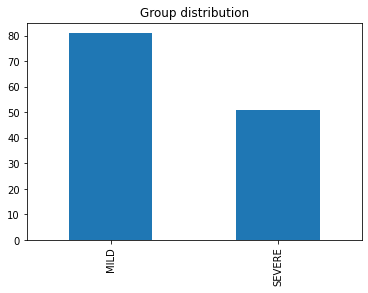

In [24]:
y.value_counts().plot(kind='bar', title='Group distribution');

Adding synthetic data to severe cases

In [30]:
smote = SMOTE(sampling_strategy ='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9124\361123966.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm


<AxesSubplot:title={'center':'Count (target)'}>

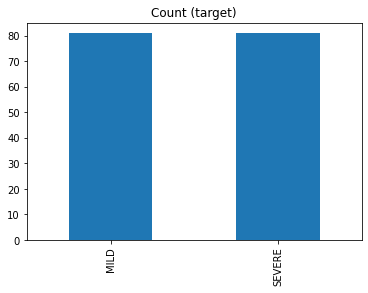

In [31]:
df = pd.DataFrame(X_sm, columns=features)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)')

#### testing the best approach for classification but now using the synthetic data

In [32]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )

In [33]:
feat_selector.fit(np.array(X_sm), y_sm)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	133
Rejected: 	413
Iteration: 	9 / 100
Confirmed: 	30
Tentative: 	103
Rejected: 	413
Iteration: 	10 / 100
Confirmed: 	30
Tentative: 	103
Rejected: 	413
Iteration: 	11 / 100
Confirmed: 	30
Tentative: 	103
Rejected: 	413
Iteration: 	12 / 100
Confirmed: 	42
Tentative: 	78
Rejected: 	426
Iteration: 	13 / 100
Confirmed: 	42
Tentative: 	78
Rejected: 	426
Iteration: 	14 / 100
Confirmed: 	42
Tentative: 	78
Rejected: 	426
Iteration: 	15 / 100
Confirmed: 	42
Tentative: 	78
Rejected: 	426
Iteration: 	16 / 100
Confirmed

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=277, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2B09132D440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B09132D440, verbose=2)

In [34]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  68


In [36]:
# Best Features (accord to Boruta)
X_sm.columns[feat_selector.support_]

Index(['Freq.1261.3335177338', 'Freq.1324.07107187346',
       'Freq.1389.01002905644', 'Freq.1477.70491383112',
       'Freq.1514.70175609701', 'Freq.1522.99914751846',
       'Freq.1571.40357692951', 'Freq.1649.08923599114',
       'Freq.1715.83254187774', 'Freq.1740.12061901788',
       'Freq.1794.21713030157', 'Freq.2032.98713905056',
       'Freq.2052.46119506721', 'Freq.2079.94829884854',
       'Freq.2100.44990262345', 'Freq.2147.21242083795',
       'Freq.2182.54012190969', 'Freq.2187.26929655148',
       'Freq.2224.44106274883', 'Freq.2241.01398322552',
       'Freq.2382.42710415359', 'Freq.2395.92741519698',
       'Freq.2461.57721259156', 'Freq.2528.65319900938',
       'Freq.2552.55336332551', 'Freq.2822.17822957638',
       'Freq.2926.79763926674', 'Freq.2981.05105455515',
       'Freq.3044.22068852996', 'Freq.3083.87231952593',
       'Freq.3275.14240190952', 'Freq.3345.67126398784',
       'Freq.3795.45160708473', 'Freq.3983.61553339652',
       'Freq.4266.97846896688', 

In [37]:
# Filter most importante features
X_transform = feat_selector.transform(np.array(X_sm))

In [38]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform, y_sm, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [39]:
study = optuna.create_study(direction="maximize")

[I 2022-06-29 19:38:15,671] A new study created in memory with name: no-name-d144b1a1-395e-4279-9fa7-d46d4a210c8e


In [50]:
study.optimize(objective, n_trials=500)

[I 2022-06-29 19:39:06,168] Trial 1 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 0.20605217695215536, 'lambda_l2': 1.2239785380058246e-07, 'num_leaves': 39, 'feature_fraction': 0.4596559877429728, 'bagging_fraction': 0.7948997591787745, 'bagging_freq': 2, 'min_child_samples': 99, 'max_depth': 721}. Best is trial 1 with value: 0.5.
[I 2022-06-29 19:39:07,781] Trial 2 finished with value: 0.914042051509199 and parameters: {'scalers': 'robust', 'lambda_l1': 2.177369899810202e-08, 'lambda_l2': 3.2859670742697715, 'num_leaves': 85, 'feature_fraction': 0.737692643977045, 'bagging_fraction': 0.44534506016219483, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 449}. Best is trial 2 with value: 0.914042051509199.
[I 2022-06-29 19:39:08,632] Trial 3 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 3.345167764867709e-08, 'lambda_l2': 0.02108389260161441, 'num_leaves': 43, 'feature_fraction': 0.8208318084125736, 'bagging_fraction':

[I 2022-06-29 19:39:29,610] Trial 22 finished with value: 0.9242097343165877 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.003323308642101618, 'lambda_l2': 6.5924200561905e-05, 'num_leaves': 65, 'feature_fraction': 0.4933957341358739, 'bagging_fraction': 0.5314966498267266, 'bagging_freq': 5, 'min_child_samples': 26, 'max_depth': 500}. Best is trial 22 with value: 0.9242097343165877.
[I 2022-06-29 19:39:31,426] Trial 23 finished with value: 0.9179124636197846 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.0038113761622490068, 'lambda_l2': 0.00013311777474451337, 'num_leaves': 106, 'feature_fraction': 0.47086362295643586, 'bagging_fraction': 0.6636992414372512, 'bagging_freq': 6, 'min_child_samples': 6, 'max_depth': 485}. Best is trial 22 with value: 0.9242097343165877.
[I 2022-06-29 19:39:32,274] Trial 24 finished with value: 0.9207589828117322 and parameters: {'scalers': 'minmax', 'lambda_l1': 8.186255072450377e-05, 'lambda_l2': 3.7787939607618425e-05, 'num_leaves': 67, '

[I 2022-06-29 19:39:55,398] Trial 43 finished with value: 0.9288385089721827 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0010735530317901878, 'lambda_l2': 3.3285041514717953e-07, 'num_leaves': 84, 'feature_fraction': 0.40496765441424276, 'bagging_fraction': 0.5763524532185418, 'bagging_freq': 6, 'min_child_samples': 11, 'max_depth': 453}. Best is trial 43 with value: 0.9288385089721827.
[I 2022-06-29 19:39:57,068] Trial 44 finished with value: 0.9263701629187732 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0007052485209935231, 'lambda_l2': 4.686841297631806e-08, 'num_leaves': 76, 'feature_fraction': 0.40858707575989184, 'bagging_fraction': 0.5808794786687884, 'bagging_freq': 7, 'min_child_samples': 10, 'max_depth': 449}. Best is trial 43 with value: 0.9288385089721827.
[I 2022-06-29 19:39:58,806] Trial 45 finished with value: 0.8998304612932424 and parameters: {'scalers': 'standard', 'lambda_l1': 0.04899084059075929, 'lambda_l2': 2.5371612373284353e-06, 'num_leaves

[I 2022-06-29 19:40:25,734] Trial 63 finished with value: 0.9280529985729712 and parameters: {'scalers': 'standard', 'lambda_l1': 4.944146666567913e-08, 'lambda_l2': 1.0295768509502422e-07, 'num_leaves': 205, 'feature_fraction': 0.4690420295736488, 'bagging_fraction': 0.4253102243482345, 'bagging_freq': 7, 'min_child_samples': 14, 'max_depth': 657}. Best is trial 60 with value: 0.9311776426627095.
[I 2022-06-29 19:40:27,832] Trial 64 finished with value: 0.9235203633879769 and parameters: {'scalers': 'standard', 'lambda_l1': 5.134403818527518e-06, 'lambda_l2': 1.7888454646244644e-08, 'num_leaves': 178, 'feature_fraction': 0.46501358396340076, 'bagging_fraction': 0.4914043862361712, 'bagging_freq': 7, 'min_child_samples': 8, 'max_depth': 585}. Best is trial 60 with value: 0.9311776426627095.
[I 2022-06-29 19:40:29,786] Trial 65 finished with value: 0.932041571768781 and parameters: {'scalers': 'standard', 'lambda_l1': 8.253586654424897e-07, 'lambda_l2': 1.6172499369925314e-06, 'num_leav

[I 2022-06-29 19:41:12,844] Trial 83 finished with value: 0.9278507206522335 and parameters: {'scalers': 'robust', 'lambda_l1': 2.0668059530333104e-08, 'lambda_l2': 4.164843368117929e-06, 'num_leaves': 231, 'feature_fraction': 0.5586697997619932, 'bagging_fraction': 0.47290617935878504, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 919}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:41:15,408] Trial 84 finished with value: 0.9296434676154522 and parameters: {'scalers': 'robust', 'lambda_l1': 2.078937732988894e-07, 'lambda_l2': 8.274475761020595e-07, 'num_leaves': 209, 'feature_fraction': 0.5977754319863, 'bagging_fraction': 0.43468774947757627, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 682}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:41:17,811] Trial 85 finished with value: 0.9295215247867774 and parameters: {'scalers': 'robust', 'lambda_l1': 2.916875233727581e-08, 'lambda_l2': 1.6937469541239112e-06, 'num_leaves': 19

[I 2022-06-29 19:42:00,908] Trial 103 finished with value: 0.9333411484176223 and parameters: {'scalers': 'standard', 'lambda_l1': 2.1376081102644684e-07, 'lambda_l2': 1.676547134945284e-07, 'num_leaves': 238, 'feature_fraction': 0.7098245246961172, 'bagging_fraction': 0.43876988673231354, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 889}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:42:03,084] Trial 104 finished with value: 0.9307326637295341 and parameters: {'scalers': 'standard', 'lambda_l1': 2.424582621150951e-07, 'lambda_l2': 1.5724966131428014e-07, 'num_leaves': 186, 'feature_fraction': 0.7452625787191773, 'bagging_fraction': 0.44155512705282784, 'bagging_freq': 1, 'min_child_samples': 13, 'max_depth': 865}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:42:04,967] Trial 105 finished with value: 0.9302907271326809 and parameters: {'scalers': 'standard', 'lambda_l1': 3.403208088621622e-08, 'lambda_l2': 8.674014993692532e-07, 'num

[I 2022-06-29 19:42:41,430] Trial 123 finished with value: 0.933075914626384 and parameters: {'scalers': 'standard', 'lambda_l1': 3.190433619873558e-07, 'lambda_l2': 8.685626096327876e-05, 'num_leaves': 157, 'feature_fraction': 0.6634585069168148, 'bagging_fraction': 0.421759082216719, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 807}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:42:43,596] Trial 124 finished with value: 0.929396760876797 and parameters: {'scalers': 'standard', 'lambda_l1': 2.7546111123018084e-06, 'lambda_l2': 0.00011069193918190641, 'num_leaves': 153, 'feature_fraction': 0.6623592872379808, 'bagging_fraction': 0.4215338057767783, 'bagging_freq': 1, 'min_child_samples': 11, 'max_depth': 772}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:42:45,606] Trial 125 finished with value: 0.9314702018902112 and parameters: {'scalers': 'standard', 'lambda_l1': 3.4215383431273967e-07, 'lambda_l2': 9.371373873843165e-05, 'num_lea

[I 2022-06-29 19:43:24,276] Trial 143 finished with value: 0.9340256189253532 and parameters: {'scalers': 'standard', 'lambda_l1': 3.6442291786621207e-07, 'lambda_l2': 1.8449948962744267e-05, 'num_leaves': 163, 'feature_fraction': 0.4868264140972709, 'bagging_fraction': 0.4149908779406806, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 807}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:43:26,313] Trial 144 finished with value: 0.9342180838391801 and parameters: {'scalers': 'standard', 'lambda_l1': 3.9572910756964723e-07, 'lambda_l2': 1.864188592300487e-05, 'num_leaves': 164, 'feature_fraction': 0.48364435048777443, 'bagging_fraction': 0.41146617515892386, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 806}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:43:28,100] Trial 145 finished with value: 0.9334371286113193 and parameters: {'scalers': 'standard', 'lambda_l1': 1.3363662588052078e-06, 'lambda_l2': 1.7470879236833094e-05, '

[I 2022-06-29 19:43:57,408] Trial 163 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 5.198162099400415e-07, 'lambda_l2': 1.6277901570275497e-05, 'num_leaves': 146, 'feature_fraction': 0.46380659475211655, 'bagging_fraction': 0.4188863642085341, 'bagging_freq': 2, 'min_child_samples': 96, 'max_depth': 853}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:43:59,132] Trial 164 finished with value: 0.9337146061077612 and parameters: {'scalers': 'standard', 'lambda_l1': 1.6613189388552843e-06, 'lambda_l2': 1.1266735013348429e-05, 'num_leaves': 153, 'feature_fraction': 0.4787119150123313, 'bagging_fraction': 0.4007843418093067, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 822}. Best is trial 79 with value: 0.9363522322984817.
[I 2022-06-29 19:44:00,929] Trial 165 finished with value: 0.9299879377597694 and parameters: {'scalers': 'standard', 'lambda_l1': 2.1174090399964946e-06, 'lambda_l2': 4.131825916361254e-05, 'num_leaves': 142,

[I 2022-06-29 19:44:30,874] Trial 183 finished with value: 0.9369904313746855 and parameters: {'scalers': 'standard', 'lambda_l1': 9.613182874151168e-07, 'lambda_l2': 7.810344762172417e-06, 'num_leaves': 157, 'feature_fraction': 0.46506865549071125, 'bagging_fraction': 0.41366785837938563, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 803}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:44:32,535] Trial 184 finished with value: 0.9347346754991542 and parameters: {'scalers': 'standard', 'lambda_l1': 2.0316751116077643e-06, 'lambda_l2': 4.8253113641305e-06, 'num_leaves': 160, 'feature_fraction': 0.46408666695927525, 'bagging_fraction': 0.4132677626616241, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 837}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:44:32,960] Trial 185 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 2.1234962776835374e-06, 'lambda_l2': 6.404600469074415e-06, 'num_leaves': 155,

[I 2022-06-29 19:45:11,086] Trial 203 finished with value: 0.9227111237295483 and parameters: {'scalers': 'standard', 'lambda_l1': 1.5727528395197768e-06, 'lambda_l2': 4.011636129209286e-06, 'num_leaves': 149, 'feature_fraction': 0.501863955628211, 'bagging_fraction': 0.6738652276973875, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 791}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:45:12,937] Trial 204 finished with value: 0.9305044590706777 and parameters: {'scalers': 'standard', 'lambda_l1': 2.159618430083055e-06, 'lambda_l2': 4.8298294098214426e-06, 'num_leaves': 144, 'feature_fraction': 0.5234805507565522, 'bagging_fraction': 0.43195596025722777, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 837}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:45:14,700] Trial 205 finished with value: 0.933372065478456 and parameters: {'scalers': 'standard', 'lambda_l1': 1.2659155065477651e-06, 'lambda_l2': 4.82502540508433e-06, 'num_

[I 2022-06-29 19:45:57,044] Trial 223 finished with value: 0.9331669222814398 and parameters: {'scalers': 'standard', 'lambda_l1': 2.5662401496476855e-07, 'lambda_l2': 4.5944715424453274e-05, 'num_leaves': 165, 'feature_fraction': 0.48563866871788525, 'bagging_fraction': 0.4110345234912725, 'bagging_freq': 2, 'min_child_samples': 13, 'max_depth': 804}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:45:59,566] Trial 224 finished with value: 0.9338752634543707 and parameters: {'scalers': 'standard', 'lambda_l1': 9.480642032610575e-07, 'lambda_l2': 8.461702396185363e-05, 'num_leaves': 175, 'feature_fraction': 0.5108381504543782, 'bagging_fraction': 0.42267591970204055, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 778}. Best is trial 183 with value: 0.9369904313746855.
[I 2022-06-29 19:46:01,680] Trial 225 finished with value: 0.9338309806742889 and parameters: {'scalers': 'standard', 'lambda_l1': 6.167644555016546e-07, 'lambda_l2': 1.154753042805987e-05, 'n

[I 2022-06-29 19:46:40,576] Trial 243 finished with value: 0.9318810207689515 and parameters: {'scalers': 'robust', 'lambda_l1': 8.704914412569978e-07, 'lambda_l2': 7.592638545665338e-05, 'num_leaves': 160, 'feature_fraction': 0.5124813159359916, 'bagging_fraction': 0.41958255695301294, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 798}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:46:42,372] Trial 244 finished with value: 0.9307706283019413 and parameters: {'scalers': 'standard', 'lambda_l1': 5.549730102828822e-07, 'lambda_l2': 8.080882149860994e-06, 'num_leaves': 166, 'feature_fraction': 0.48893904248128817, 'bagging_fraction': 0.42396192954994144, 'bagging_freq': 2, 'min_child_samples': 17, 'max_depth': 838}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:46:44,307] Trial 245 finished with value: 0.9338156257022021 and parameters: {'scalers': 'standard', 'lambda_l1': 2.1029795958860315e-07, 'lambda_l2': 2.9743069160785043e-05, 'nu

[I 2022-06-29 19:47:16,942] Trial 263 finished with value: 0.9183685428432787 and parameters: {'scalers': 'standard', 'lambda_l1': 1.8588015795719282e-07, 'lambda_l2': 1.6983327290371544e-06, 'num_leaves': 171, 'feature_fraction': 0.4698803197160043, 'bagging_fraction': 0.7431652827618919, 'bagging_freq': 2, 'min_child_samples': 14, 'max_depth': 763}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:47:18,784] Trial 264 finished with value: 0.9322578876166758 and parameters: {'scalers': 'standard', 'lambda_l1': 5.803970053000262e-07, 'lambda_l2': 9.009326197134328e-06, 'num_leaves': 154, 'feature_fraction': 0.4542141480995214, 'bagging_fraction': 0.4258170153692544, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 827}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:47:20,664] Trial 265 finished with value: 0.9280492534146206 and parameters: {'scalers': 'standard', 'lambda_l1': 1.1065197610793167e-06, 'lambda_l2': 3.056227992406628e-06, 'nu

[I 2022-06-29 19:48:10,701] Trial 283 finished with value: 0.9287471796573626 and parameters: {'scalers': 'robust', 'lambda_l1': 3.423767932478051e-06, 'lambda_l2': 0.03084074841013583, 'num_leaves': 181, 'feature_fraction': 0.45071438665952007, 'bagging_fraction': 0.4002329011367216, 'bagging_freq': 1, 'min_child_samples': 6, 'max_depth': 718}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:48:13,478] Trial 284 finished with value: 0.9349985367239287 and parameters: {'scalers': 'robust', 'lambda_l1': 2.0877275147898968e-06, 'lambda_l2': 0.0014058871648335958, 'num_leaves': 183, 'feature_fraction': 0.45127831850351924, 'bagging_fraction': 0.4004526135375348, 'bagging_freq': 1, 'min_child_samples': 5, 'max_depth': 722}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:48:16,459] Trial 285 finished with value: 0.9307498725269288 and parameters: {'scalers': 'robust', 'lambda_l1': 5.854725351263907e-06, 'lambda_l2': 0.003254441892467255, 'num_leaves': 

[I 2022-06-29 19:49:01,424] Trial 303 finished with value: 0.9316292768987864 and parameters: {'scalers': 'robust', 'lambda_l1': 1.2725245870876116e-06, 'lambda_l2': 0.00012551812397112007, 'num_leaves': 108, 'feature_fraction': 0.46314351073726034, 'bagging_fraction': 0.42257820131707585, 'bagging_freq': 1, 'min_child_samples': 7, 'max_depth': 738}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:49:03,665] Trial 304 finished with value: 0.9318275203832901 and parameters: {'scalers': 'robust', 'lambda_l1': 2.3396213017270415e-06, 'lambda_l2': 1.5668177505518352e-06, 'num_leaves': 129, 'feature_fraction': 0.5114051648568239, 'bagging_fraction': 0.4208746030516468, 'bagging_freq': 1, 'min_child_samples': 12, 'max_depth': 778}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:49:06,699] Trial 305 finished with value: 0.9276864657539632 and parameters: {'scalers': 'robust', 'lambda_l1': 8.791689814589087e-07, 'lambda_l2': 0.5190504622074944, 'num_leave

[I 2022-06-29 19:49:44,824] Trial 323 finished with value: 0.9277945197871332 and parameters: {'scalers': 'robust', 'lambda_l1': 3.699783130439219e-07, 'lambda_l2': 1.6254510213828947e-06, 'num_leaves': 174, 'feature_fraction': 0.512175978997948, 'bagging_fraction': 0.4390835135956038, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 804}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:49:46,858] Trial 324 finished with value: 0.9306833148296418 and parameters: {'scalers': 'robust', 'lambda_l1': 7.067703472410557e-06, 'lambda_l2': 2.9378837196689068e-06, 'num_leaves': 159, 'feature_fraction': 0.43323439126879, 'bagging_fraction': 0.42575494531559316, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 821}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:49:48,371] Trial 325 finished with value: 0.8936221474837288 and parameters: {'scalers': 'robust', 'lambda_l1': 6.390891157578716e-07, 'lambda_l2': 8.235432214797658, 'num_leaves': 17

[I 2022-06-29 19:50:33,460] Trial 343 finished with value: 0.9323571070966247 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.5826736832075397e-07, 'lambda_l2': 8.143213811842847e-06, 'num_leaves': 178, 'feature_fraction': 0.45184483644802215, 'bagging_fraction': 0.44329441488383675, 'bagging_freq': 1, 'min_child_samples': 8, 'max_depth': 647}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:50:35,949] Trial 344 finished with value: 0.9314787965237302 and parameters: {'scalers': 'robust', 'lambda_l1': 8.094463402764107e-07, 'lambda_l2': 0.00015281032257420614, 'num_leaves': 174, 'feature_fraction': 0.4781299399948953, 'bagging_fraction': 0.4212424229902666, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 693}. Best is trial 238 with value: 0.9377604848506214.
[I 2022-06-29 19:50:38,343] Trial 345 finished with value: 0.9312611967365132 and parameters: {'scalers': 'robust', 'lambda_l1': 4.2654634748424355e-07, 'lambda_l2': 4.440163567106132e-06, 'num_lea

[I 2022-06-29 19:51:19,510] Trial 363 finished with value: 0.9342893062539381 and parameters: {'scalers': 'robust', 'lambda_l1': 7.078973161271077e-07, 'lambda_l2': 4.61074189079336e-05, 'num_leaves': 175, 'feature_fraction': 0.47574225363151684, 'bagging_fraction': 0.4001980657155011, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 826}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:51:22,338] Trial 364 finished with value: 0.9337553937654978 and parameters: {'scalers': 'robust', 'lambda_l1': 8.611567790628549e-08, 'lambda_l2': 7.762306835423635e-05, 'num_leaves': 181, 'feature_fraction': 0.5022217110741087, 'bagging_fraction': 0.40040330214293113, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 855}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:51:24,822] Trial 365 finished with value: 0.9323374279593741 and parameters: {'scalers': 'robust', 'lambda_l1': 2.895131427961196e-07, 'lambda_l2': 0.00011048150056429932, 'num_leave

[I 2022-06-29 19:52:01,693] Trial 383 finished with value: 0.929736932264838 and parameters: {'scalers': 'standard', 'lambda_l1': 1.247528191637468e-06, 'lambda_l2': 0.0003252571116966421, 'num_leaves': 149, 'feature_fraction': 0.5037317505075158, 'bagging_fraction': 0.4308824854862404, 'bagging_freq': 4, 'min_child_samples': 14, 'max_depth': 885}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:52:03,486] Trial 384 finished with value: 0.9313840376319513 and parameters: {'scalers': 'standard', 'lambda_l1': 5.013502474079044e-07, 'lambda_l2': 0.00031480909873877815, 'num_leaves': 159, 'feature_fraction': 0.46657380423232986, 'bagging_fraction': 0.40003362306577095, 'bagging_freq': 3, 'min_child_samples': 16, 'max_depth': 819}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:52:05,289] Trial 385 finished with value: 0.9345307819554775 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.4900984065826427e-07, 'lambda_l2': 1.2959988266015183e-05, 'num

[I 2022-06-29 19:52:41,016] Trial 403 finished with value: 0.9262208722369748 and parameters: {'scalers': 'standard', 'lambda_l1': 2.572797852167626e-07, 'lambda_l2': 1.123597670954571e-05, 'num_leaves': 143, 'feature_fraction': 0.49633425045791923, 'bagging_fraction': 0.41161452257533215, 'bagging_freq': 7, 'min_child_samples': 22, 'max_depth': 830}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:52:43,009] Trial 404 finished with value: 0.9291115338274443 and parameters: {'scalers': 'standard', 'lambda_l1': 0.014765207513306249, 'lambda_l2': 2.96924572846346e-05, 'num_leaves': 55, 'feature_fraction': 0.4825222432403698, 'bagging_fraction': 0.4240889662616361, 'bagging_freq': 2, 'min_child_samples': 16, 'max_depth': 875}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:52:44,957] Trial 405 finished with value: 0.9353591749172665 and parameters: {'scalers': 'standard', 'lambda_l1': 4.03849487749753e-08, 'lambda_l2': 6.551452270694558e-06, 'num_lea

[I 2022-06-29 19:53:20,348] Trial 423 finished with value: 0.9304259806820211 and parameters: {'scalers': 'standard', 'lambda_l1': 4.65049088267932e-06, 'lambda_l2': 0.007960895885344937, 'num_leaves': 155, 'feature_fraction': 0.45167449363648643, 'bagging_fraction': 0.41991984778917735, 'bagging_freq': 4, 'min_child_samples': 8, 'max_depth': 825}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:53:22,563] Trial 424 finished with value: 0.931395854311144 and parameters: {'scalers': 'robust', 'lambda_l1': 4.360871801639543e-07, 'lambda_l2': 1.78685913412027e-05, 'num_leaves': 175, 'feature_fraction': 0.46885748325372256, 'bagging_fraction': 0.40013395974568206, 'bagging_freq': 6, 'min_child_samples': 10, 'max_depth': 890}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:53:25,362] Trial 425 finished with value: 0.9282166702770839 and parameters: {'scalers': 'standard', 'lambda_l1': 3.2402447921244254e-07, 'lambda_l2': 0.039095189271324104, 'num_leav

[I 2022-06-29 19:54:03,210] Trial 443 finished with value: 0.9315207361802211 and parameters: {'scalers': 'standard', 'lambda_l1': 7.383794225738392e-07, 'lambda_l2': 4.1450999039491465e-05, 'num_leaves': 167, 'feature_fraction': 0.48586867352225505, 'bagging_fraction': 0.40028726511947216, 'bagging_freq': 6, 'min_child_samples': 9, 'max_depth': 873}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:54:05,210] Trial 444 finished with value: 0.9330594607425523 and parameters: {'scalers': 'robust', 'lambda_l1': 3.733875165865139e-08, 'lambda_l2': 2.562235711015992e-05, 'num_leaves': 151, 'feature_fraction': 0.45928625649003035, 'bagging_fraction': 0.4000151964903762, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 807}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:54:06,780] Trial 445 finished with value: 0.9269473968518508 and parameters: {'scalers': 'standard', 'lambda_l1': 5.701963909683071e-06, 'lambda_l2': 0.2853968889573912, 'num_lea

[I 2022-06-29 19:54:43,177] Trial 463 finished with value: 0.9331550816389454 and parameters: {'scalers': 'standard', 'lambda_l1': 7.158819207058224e-08, 'lambda_l2': 1.457037847833196e-06, 'num_leaves': 162, 'feature_fraction': 0.466557843816529, 'bagging_fraction': 0.4287910339331449, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 753}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:54:45,438] Trial 464 finished with value: 0.9294784245401927 and parameters: {'scalers': 'standard', 'lambda_l1': 2.264645411648427e-07, 'lambda_l2': 1.988988139198735e-06, 'num_leaves': 179, 'feature_fraction': 0.9233085228753579, 'bagging_fraction': 0.42009881838227264, 'bagging_freq': 2, 'min_child_samples': 12, 'max_depth': 779}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:54:47,282] Trial 465 finished with value: 0.9365547384126769 and parameters: {'scalers': 'standard', 'lambda_l1': 3.400213336112774e-07, 'lambda_l2': 3.1982515600288215e-06, 'num_

[I 2022-06-29 19:55:20,005] Trial 483 finished with value: 0.9346250926081068 and parameters: {'scalers': 'standard', 'lambda_l1': 3.83568193061993e-08, 'lambda_l2': 3.5153685029217604e-06, 'num_leaves': 153, 'feature_fraction': 0.4597498964238983, 'bagging_fraction': 0.41197825592140047, 'bagging_freq': 3, 'min_child_samples': 9, 'max_depth': 840}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:55:22,409] Trial 484 finished with value: 0.9272349478371572 and parameters: {'scalers': 'standard', 'lambda_l1': 1.5331973214974423e-08, 'lambda_l2': 1.9129174420506995e-06, 'num_leaves': 165, 'feature_fraction': 0.40037629847897815, 'bagging_fraction': 0.4351291551606836, 'bagging_freq': 5, 'min_child_samples': 11, 'max_depth': 761}. Best is trial 347 with value: 0.9378675693510884.
[I 2022-06-29 19:55:24,671] Trial 485 finished with value: 0.9338736458264743 and parameters: {'scalers': 'standard', 'lambda_l1': 6.251244978263885e-08, 'lambda_l2': 7.479957421078682e-06, 'nu

In [51]:
# Get best trial based on metric score
trial = study.best_trial

In [52]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: robust
    lambda_l1: 2.3530014630575774e-07
    lambda_l2: 9.189680143506189e-06
    num_leaves: 166
    feature_fraction: 0.4394340116965095
    bagging_fraction: 0.4146478566749443
    bagging_freq: 3
    min_child_samples: 11
    max_depth: 813


In [53]:
# Best Score from HP Opt
trial.values[0]

0.9378675693510884

Possivel overfit causado pelo SMOTE

In [54]:
gbm_opt = lgb.LGBMClassifier(random_state=SEED, **trial.params)

- Pré selecionar as features mais importantes auxiliou a obter uma performance ainda melhor a partir do pipeline com Robust Scaler e LightGBM

In [55]:
X_transform_test = feat_selector.transform(np.array(X_test))

In [56]:
X_transform_test.shape

(64, 68)

In [58]:
gbm_opt.fit(X_transform,y_sm)

[LightGBM] [Warning] Unknown parameter: scalers
[LightGBM] [Warning] feature_fraction is set=0.4394340116965095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4394340116965095
[LightGBM] [Warning] lambda_l1 is set=2.3530014630575774e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3530014630575774e-07
[LightGBM] [Warning] bagging_fraction is set=0.4146478566749443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4146478566749443
[LightGBM] [Warning] lambda_l2 is set=9.189680143506189e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.189680143506189e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


LGBMClassifier(bagging_fraction=0.4146478566749443, bagging_freq=3,
               feature_fraction=0.4394340116965095,
               lambda_l1=2.3530014630575774e-07,
               lambda_l2=9.189680143506189e-06, max_depth=813,
               min_child_samples=11, num_leaves=166, random_state=42,
               scalers='robust')

In [59]:
y_pred = gbm_opt.predict(X_transform_test)

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.75      0.64      0.69        42
      SEVERE       0.46      0.59      0.52        22

    accuracy                           0.62        64
   macro avg       0.61      0.62      0.61        64
weighted avg       0.65      0.62      0.63        64



* testando outro tipo de SMOTE (KNN smote)

In [63]:
smoteKnn = KMeansSMOTE(sampling_strategy ='minority', n_jobs=-1)
X_sm_knn, y_sm_knn = smoteKnn.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9124\2222850431.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm_knn


<AxesSubplot:title={'center':'Count (target)'}>

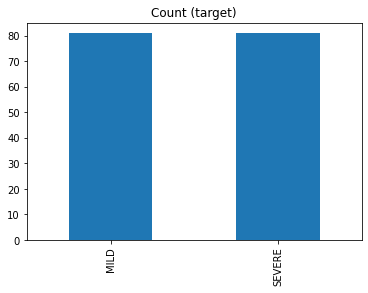

In [64]:
df = pd.DataFrame(X_sm_knn, columns=features)
df['target'] = y_sm_knn

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [66]:
feat_selector.fit(np.array(X_sm_knn), y_sm_knn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	127
Rejected: 	419
Iteration: 	9 / 100
Confirmed: 	42
Tentative: 	85
Rejected: 	419
Iteration: 	10 / 100
Confirmed: 	42
Tentative: 	85
Rejected: 	419
Iteration: 	11 / 100
Confirmed: 	42
Tentative: 	85
Rejected: 	419
Iteration: 	12 / 100
Confirmed: 	42
Tentative: 	63
Rejected: 	441
Iteration: 	13 / 100
Confirmed: 	42
Tentative: 	63
Rejected: 	441
Iteration: 	14 / 100
Confirmed: 	42
Tentative: 	63
Rejected: 	441
Iteration: 	15 / 100
Confirmed: 	42
Tentative: 	63
Rejected: 	441
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=252, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2B096C88240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B096C88240, verbose=2)

In [67]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  51


In [68]:
# Best Features (accord to Boruta)
X_sm_knn.columns[feat_selector.support_]

Index(['Freq.1522.99914751846', 'Freq.1715.83254187774',
       'Freq.1740.12061901788', 'Freq.1794.21713030157',
       'Freq.1987.25255033859', 'Freq.2032.98713905056',
       'Freq.2100.44990262345', 'Freq.2182.54012190969',
       'Freq.2187.26929655148', 'Freq.2241.01398322552',
       'Freq.2245.38681433931', 'Freq.2461.57721259156',
       'Freq.2822.17822957638', 'Freq.2981.05105455515',
       'Freq.3044.22068852996', 'Freq.3083.87231952593',
       'Freq.3224.56422573788', 'Freq.3275.14240190952',
       'Freq.3795.45160708473', 'Freq.3983.61553339652',
       'Freq.4008.05278467097', 'Freq.4266.97846896688',
       'Freq.4283.95182164633', 'Freq.4307.03317519015',
       'Freq.4374.2137825978', 'Freq.4387.43710765143',
       'Freq.4395.11277752994', 'Freq.4411.09910211658',
       'Freq.4475.30783710944', 'Freq.4659.55667096198',
       'Freq.4773.1456453954', 'Freq.4802.98802524845',
       'Freq.4823.08140765752', 'Freq.4913.21517050264',
       'Freq.5034.76690113434', '

In [69]:
# Filter most importante features
X_transform_knn = feat_selector.transform(np.array(X_sm_knn))

In [70]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform_knn, y_sm_knn, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [71]:
study = optuna.create_study(direction="maximize")

[I 2022-06-29 20:06:43,969] A new study created in memory with name: no-name-7edc73fb-ca10-401c-b19b-c6b349915cd4


In [72]:
study.optimize(objective, n_trials=500)

[I 2022-06-29 20:06:49,636] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 9.051180041322293e-08, 'lambda_l2': 1.3106191653901783e-06, 'num_leaves': 80, 'feature_fraction': 0.86999628591, 'bagging_fraction': 0.7650747327262928, 'bagging_freq': 3, 'min_child_samples': 64, 'max_depth': 813}. Best is trial 0 with value: 0.5.
[I 2022-06-29 20:06:50,023] Trial 1 finished with value: 0.569731342402008 and parameters: {'scalers': 'standard', 'lambda_l1': 0.6682531483053359, 'lambda_l2': 0.12285404183560707, 'num_leaves': 125, 'feature_fraction': 0.5395221537251671, 'bagging_fraction': 0.5412121101810925, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 254}. Best is trial 1 with value: 0.569731342402008.
[I 2022-06-29 20:06:50,586] Trial 2 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 2.3439716650907093e-08, 'lambda_l2': 1.5133822419771404e-06, 'num_leaves': 40, 'feature_fraction': 0.4532617071370242, 'bagging_fraction

[I 2022-06-29 20:07:19,004] Trial 21 finished with value: 0.8886919661230469 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.3064296227309577e-05, 'lambda_l2': 0.004264985968707868, 'num_leaves': 200, 'feature_fraction': 0.52768602820522, 'bagging_fraction': 0.6739007488615665, 'bagging_freq': 2, 'min_child_samples': 42, 'max_depth': 617}. Best is trial 4 with value: 0.8944742729190164.
[I 2022-06-29 20:07:20,144] Trial 22 finished with value: 0.8809525053559161 and parameters: {'scalers': 'minmax', 'lambda_l1': 4.7175829277802997e-07, 'lambda_l2': 0.01067439116245583, 'num_leaves': 194, 'feature_fraction': 0.49821517350190914, 'bagging_fraction': 0.7784582383583272, 'bagging_freq': 2, 'min_child_samples': 52, 'max_depth': 719}. Best is trial 4 with value: 0.8944742729190164.
[I 2022-06-29 20:07:21,816] Trial 23 finished with value: 0.8899054702261815 and parameters: {'scalers': 'minmax', 'lambda_l1': 4.204226475187237e-05, 'lambda_l2': 0.0002556781709120269, 'num_leaves': 255, 'f

[I 2022-06-29 20:07:50,772] Trial 41 finished with value: 0.895284270662333 and parameters: {'scalers': 'standard', 'lambda_l1': 1.6241832780056702e-08, 'lambda_l2': 1.0239267739928959e-07, 'num_leaves': 235, 'feature_fraction': 0.6229922655486145, 'bagging_fraction': 0.5331337231289228, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 886}. Best is trial 36 with value: 0.8990005536194038.
[I 2022-06-29 20:07:52,618] Trial 42 finished with value: 0.8871113057563201 and parameters: {'scalers': 'standard', 'lambda_l1': 0.19309208950592924, 'lambda_l2': 2.653429566163004e-07, 'num_leaves': 69, 'feature_fraction': 0.5909894370884015, 'bagging_fraction': 0.640499846146071, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 756}. Best is trial 36 with value: 0.8990005536194038.
[I 2022-06-29 20:07:53,097] Trial 43 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 1.0553042851733133e-08, 'lambda_l2': 1.0243150713760243e-08, 'num_leaves': 238, 'feature

[I 2022-06-29 20:08:27,193] Trial 61 finished with value: 0.8946417977811589 and parameters: {'scalers': 'standard', 'lambda_l1': 2.8246024902399846e-07, 'lambda_l2': 5.156331836741503e-08, 'num_leaves': 169, 'feature_fraction': 0.5077162627741508, 'bagging_fraction': 0.5751856666083911, 'bagging_freq': 3, 'min_child_samples': 28, 'max_depth': 930}. Best is trial 52 with value: 0.9002015314341588.
[I 2022-06-29 20:08:29,084] Trial 62 finished with value: 0.9004253701169758 and parameters: {'scalers': 'standard', 'lambda_l1': 5.1414067665658224e-08, 'lambda_l2': 1.4474645003885611e-08, 'num_leaves': 196, 'feature_fraction': 0.5918384145359636, 'bagging_fraction': 0.4858226479100674, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 964}. Best is trial 62 with value: 0.9004253701169758.
[I 2022-06-29 20:08:30,799] Trial 63 finished with value: 0.8955056717028131 and parameters: {'scalers': 'standard', 'lambda_l1': 9.696778759887887e-07, 'lambda_l2': 1.4184495197007592e-08, 'num_le

[I 2022-06-29 20:09:03,578] Trial 81 finished with value: 0.8953048947031566 and parameters: {'scalers': 'standard', 'lambda_l1': 0.006926198452519221, 'lambda_l2': 2.0578241582891822e-08, 'num_leaves': 154, 'feature_fraction': 0.6701641201209418, 'bagging_fraction': 0.6080773776372022, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 933}. Best is trial 62 with value: 0.9004253701169758.
[I 2022-06-29 20:09:05,545] Trial 82 finished with value: 0.897277888070037 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0002689445080722996, 'lambda_l2': 6.294479937485944e-08, 'num_leaves': 188, 'feature_fraction': 0.6318777366115675, 'bagging_fraction': 0.6622731444348658, 'bagging_freq': 3, 'min_child_samples': 26, 'max_depth': 997}. Best is trial 62 with value: 0.9004253701169758.
[I 2022-06-29 20:09:07,603] Trial 83 finished with value: 0.8933991817809627 and parameters: {'scalers': 'standard', 'lambda_l1': 0.027180768952538594, 'lambda_l2': 4.25972599208966e-08, 'num_leaves': 

[I 2022-06-29 20:09:38,006] Trial 101 finished with value: 0.8967351215540491 and parameters: {'scalers': 'robust', 'lambda_l1': 3.93967388609065e-08, 'lambda_l2': 3.754416929975402e-05, 'num_leaves': 53, 'feature_fraction': 0.7596423435699415, 'bagging_fraction': 0.4334901417233071, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 649}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:09:39,943] Trial 102 finished with value: 0.8939486193855052 and parameters: {'scalers': 'robust', 'lambda_l1': 2.9155145299074805e-08, 'lambda_l2': 0.0009306525989535842, 'num_leaves': 21, 'feature_fraction': 0.8455872977754276, 'bagging_fraction': 0.505274052098147, 'bagging_freq': 2, 'min_child_samples': 18, 'max_depth': 532}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:09:41,875] Trial 103 finished with value: 0.8965130534109703 and parameters: {'scalers': 'robust', 'lambda_l1': 1.8406385889917432e-07, 'lambda_l2': 1.4385233621344641e-05, 'num_leaves': 8

[I 2022-06-29 20:10:11,325] Trial 121 finished with value: 0.8966096727928822 and parameters: {'scalers': 'standard', 'lambda_l1': 5.697127142568549e-08, 'lambda_l2': 2.241970120080268e-05, 'num_leaves': 44, 'feature_fraction': 0.7771872424512285, 'bagging_fraction': 0.5734126448032053, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 683}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:10:13,188] Trial 122 finished with value: 0.9001313067102203 and parameters: {'scalers': 'standard', 'lambda_l1': 6.782672725823254e-08, 'lambda_l2': 2.4508648131166054e-06, 'num_leaves': 46, 'feature_fraction': 0.7682095920401826, 'bagging_fraction': 0.542817928102435, 'bagging_freq': 1, 'min_child_samples': 19, 'max_depth': 694}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:10:14,979] Trial 123 finished with value: 0.9012051654140343 and parameters: {'scalers': 'standard', 'lambda_l1': 1.052598660015557e-07, 'lambda_l2': 2.303125221232525e-06, 'num_leave

[I 2022-06-29 20:10:43,011] Trial 141 finished with value: 0.8988302049622131 and parameters: {'scalers': 'standard', 'lambda_l1': 1.234935361431942e-07, 'lambda_l2': 1.8292450985979459e-06, 'num_leaves': 30, 'feature_fraction': 0.7659963704228692, 'bagging_fraction': 0.45855759822292325, 'bagging_freq': 2, 'min_child_samples': 21, 'max_depth': 731}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:10:44,704] Trial 142 finished with value: 0.8967303674576946 and parameters: {'scalers': 'standard', 'lambda_l1': 3.3140736869921856e-08, 'lambda_l2': 2.6062417420679364e-06, 'num_leaves': 52, 'feature_fraction': 0.7067918516434217, 'bagging_fraction': 0.5243285111729203, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 674}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:10:46,365] Trial 143 finished with value: 0.8982992625289116 and parameters: {'scalers': 'standard', 'lambda_l1': 7.677297534716069e-08, 'lambda_l2': 8.75884187286937e-06, 'num_le

[I 2022-06-29 20:11:15,821] Trial 161 finished with value: 0.8958692477262944 and parameters: {'scalers': 'robust', 'lambda_l1': 8.658206459944603e-08, 'lambda_l2': 8.392142080030026e-06, 'num_leaves': 27, 'feature_fraction': 0.8006319279786186, 'bagging_fraction': 0.46860794875418077, 'bagging_freq': 1, 'min_child_samples': 17, 'max_depth': 674}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:11:17,307] Trial 162 finished with value: 0.9029805172402342 and parameters: {'scalers': 'robust', 'lambda_l1': 1.7994686145209408e-07, 'lambda_l2': 5.9899737965129526e-05, 'num_leaves': 43, 'feature_fraction': 0.8102523988271126, 'bagging_fraction': 0.5162824409109936, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 616}. Best is trial 97 with value: 0.9034751275855057.
[I 2022-06-29 20:11:18,848] Trial 163 finished with value: 0.8966442366412246 and parameters: {'scalers': 'robust', 'lambda_l1': 1.4449430774881807e-07, 'lambda_l2': 6.31044535444531e-05, 'num_leaves':

[I 2022-06-29 20:11:47,723] Trial 181 finished with value: 0.8990325398510047 and parameters: {'scalers': 'standard', 'lambda_l1': 2.3117267582034567e-08, 'lambda_l2': 0.0032216054765583017, 'num_leaves': 50, 'feature_fraction': 0.7647846560879625, 'bagging_fraction': 0.552689526895813, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 549}. Best is trial 173 with value: 0.9035940431911458.
[I 2022-06-29 20:11:48,845] Trial 182 finished with value: 0.8743808267335408 and parameters: {'scalers': 'standard', 'lambda_l1': 1.6298152994607653, 'lambda_l2': 1.541189125546703e-06, 'num_leaves': 39, 'feature_fraction': 0.8012483493456788, 'bagging_fraction': 0.5708205394165504, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 578}. Best is trial 173 with value: 0.9035940431911458.
[I 2022-06-29 20:11:50,575] Trial 183 finished with value: 0.9013685602547494 and parameters: {'scalers': 'standard', 'lambda_l1': 3.5693440216953674e-08, 'lambda_l2': 2.604502161003293e-06, 'num_leave

[I 2022-06-29 20:12:14,773] Trial 201 finished with value: 0.8970254311616204 and parameters: {'scalers': 'standard', 'lambda_l1': 7.131640615650499e-08, 'lambda_l2': 7.921205435223721e-07, 'num_leaves': 46, 'feature_fraction': 0.76510653316621, 'bagging_fraction': 0.5516926195814946, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 570}. Best is trial 173 with value: 0.9035940431911458.
[I 2022-06-29 20:12:15,674] Trial 202 finished with value: 0.8861913897085775 and parameters: {'scalers': 'standard', 'lambda_l1': 2.2219535070353247e-08, 'lambda_l2': 1.876435083064886e-06, 'num_leaves': 29, 'feature_fraction': 0.7701817535923162, 'bagging_fraction': 0.5425651429454567, 'bagging_freq': 1, 'min_child_samples': 15, 'max_depth': 191}. Best is trial 173 with value: 0.9035940431911458.
[I 2022-06-29 20:12:17,448] Trial 203 finished with value: 0.9000897152177775 and parameters: {'scalers': 'standard', 'lambda_l1': 1.542536908714633e-07, 'lambda_l2': 4.818529695944036e-06, 'num_leav

[I 2022-06-29 20:12:40,842] Trial 221 finished with value: 0.8999638656127079 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.0485326796141267e-07, 'lambda_l2': 5.2821813595468247e-05, 'num_leaves': 58, 'feature_fraction': 0.7938342360203424, 'bagging_fraction': 0.5042586790764656, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 513}. Best is trial 215 with value: 0.903968063105102.
[I 2022-06-29 20:12:42,496] Trial 222 finished with value: 0.9026898563551881 and parameters: {'scalers': 'minmax', 'lambda_l1': 7.157734138458776e-08, 'lambda_l2': 6.73030919441893e-05, 'num_leaves': 47, 'feature_fraction': 0.7825803033626184, 'bagging_fraction': 0.4915735560723949, 'bagging_freq': 1, 'min_child_samples': 20, 'max_depth': 565}. Best is trial 215 with value: 0.903968063105102.
[I 2022-06-29 20:12:44,241] Trial 223 finished with value: 0.897495297402191 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.6356935561528633e-07, 'lambda_l2': 6.053153061347563e-05, 'num_leaves': 5

[I 2022-06-29 20:13:09,216] Trial 241 finished with value: 0.9008543293875775 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.0032008411392892e-08, 'lambda_l2': 9.621556178647454e-05, 'num_leaves': 59, 'feature_fraction': 0.7688890997820705, 'bagging_fraction': 0.5428556406133418, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 546}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:10,687] Trial 242 finished with value: 0.9017842758955797 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.5674757410401695e-08, 'lambda_l2': 0.0001315559275747952, 'num_leaves': 48, 'feature_fraction': 0.774400308433195, 'bagging_fraction': 0.5442071892260372, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 543}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:11,785] Trial 243 finished with value: 0.9020119756768783 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.9124639826446594e-08, 'lambda_l2': 9.883255782756842e-05, 'num_leaves'

[I 2022-06-29 20:13:32,597] Trial 261 finished with value: 0.8941273883644659 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.496617302714261e-08, 'lambda_l2': 6.715316642351817e-05, 'num_leaves': 52, 'feature_fraction': 0.8379953426640385, 'bagging_fraction': 0.5174011633699928, 'bagging_freq': 1, 'min_child_samples': 28, 'max_depth': 521}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:33,727] Trial 262 finished with value: 0.9022613031113081 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.4365365076414441e-08, 'lambda_l2': 0.00011819404881349758, 'num_leaves': 47, 'feature_fraction': 0.827737581484101, 'bagging_fraction': 0.5344892634679311, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 553}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:34,940] Trial 263 finished with value: 0.8997557081870582 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.2873578774187814e-08, 'lambda_l2': 8.354572338988613e-05, 'num_leaves'

[I 2022-06-29 20:13:54,644] Trial 281 finished with value: 0.8993561821455043 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.0674664712664031e-08, 'lambda_l2': 0.0005464988718082986, 'num_leaves': 41, 'feature_fraction': 0.7361279407635734, 'bagging_fraction': 0.5187215915046417, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 536}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:55,834] Trial 282 finished with value: 0.895092190296878 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.7883902876308568e-08, 'lambda_l2': 0.00017507647748956663, 'num_leaves': 44, 'feature_fraction': 0.7924527175751105, 'bagging_fraction': 0.5007216105120101, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 567}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:13:56,846] Trial 283 finished with value: 0.8940412787686058 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.0087142068895329e-08, 'lambda_l2': 8.730471794819668e-05, 'num_leaves

[I 2022-06-29 20:14:16,144] Trial 301 finished with value: 0.8990398340274165 and parameters: {'scalers': 'minmax', 'lambda_l1': 5.154453251566571e-08, 'lambda_l2': 0.00021418791021699806, 'num_leaves': 55, 'feature_fraction': 0.7882518962241211, 'bagging_fraction': 0.5196223977726102, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 533}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:14:17,120] Trial 302 finished with value: 0.8973632784848375 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.4155494153688901e-08, 'lambda_l2': 0.0001371179905040517, 'num_leaves': 44, 'feature_fraction': 0.8150571826922753, 'bagging_fraction': 0.5460480562405345, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 510}. Best is trial 239 with value: 0.9047793126645344.
[I 2022-06-29 20:14:18,519] Trial 303 finished with value: 0.8991099150901447 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.0010004464726775884, 'lambda_l2': 4.091222553277041e-05, 'num_leaves'

[I 2022-06-29 20:14:37,499] Trial 321 finished with value: 0.9009076688789217 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.3628722204347201e-08, 'lambda_l2': 2.7580578745585222e-05, 'num_leaves': 27, 'feature_fraction': 0.749002726032783, 'bagging_fraction': 0.5312090040747806, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 598}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:14:38,627] Trial 322 finished with value: 0.8990448101025147 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.249097575307664e-08, 'lambda_l2': 0.00018295229297635176, 'num_leaves': 41, 'feature_fraction': 0.7596981377731492, 'bagging_fraction': 0.5607660832701524, 'bagging_freq': 1, 'min_child_samples': 25, 'max_depth': 563}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:14:39,546] Trial 323 finished with value: 0.8966508863737629 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.6406710235991925e-08, 'lambda_l2': 0.0003277687164339423, 'num_leaves

[I 2022-06-29 20:14:59,196] Trial 341 finished with value: 0.8901945440909129 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.4281467927295233e-05, 'lambda_l2': 3.0746287254814e-05, 'num_leaves': 42, 'feature_fraction': 0.729731414782815, 'bagging_fraction': 0.5290853596345191, 'bagging_freq': 1, 'min_child_samples': 29, 'max_depth': 355}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:00,310] Trial 342 finished with value: 0.9017468130574201 and parameters: {'scalers': 'minmax', 'lambda_l1': 5.039318355131621e-08, 'lambda_l2': 0.00011618783562943893, 'num_leaves': 48, 'feature_fraction': 0.700770072906646, 'bagging_fraction': 0.5492982150343898, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 520}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:01,543] Trial 343 finished with value: 0.9016998075818156 and parameters: {'scalers': 'minmax', 'lambda_l1': 6.315018936412664e-08, 'lambda_l2': 9.31129164379311e-05, 'num_leaves': 71,

[I 2022-06-29 20:15:22,374] Trial 361 finished with value: 0.8975667434355177 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.872796136354432e-08, 'lambda_l2': 0.00010666022809124318, 'num_leaves': 58, 'feature_fraction': 0.7679170316185395, 'bagging_fraction': 0.5046157316445343, 'bagging_freq': 1, 'min_child_samples': 16, 'max_depth': 509}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:23,712] Trial 362 finished with value: 0.8941943147665739 and parameters: {'scalers': 'minmax', 'lambda_l1': 7.55736777882875e-08, 'lambda_l2': 7.764215135717464e-05, 'num_leaves': 48, 'feature_fraction': 0.7352984181590655, 'bagging_fraction': 0.6725809052823961, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 568}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:24,913] Trial 363 finished with value: 0.898450742992892 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.6208307731316184e-08, 'lambda_l2': 3.684676039197919e-05, 'num_leaves': 

[I 2022-06-29 20:15:49,145] Trial 381 finished with value: 0.8956897051326651 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.2591288709311623e-08, 'lambda_l2': 2.548719830971627e-05, 'num_leaves': 61, 'feature_fraction': 0.7345676163372794, 'bagging_fraction': 0.4852453473646605, 'bagging_freq': 1, 'min_child_samples': 27, 'max_depth': 602}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:49,629] Trial 382 finished with value: 0.6812377668985641 and parameters: {'scalers': 'minmax', 'lambda_l1': 5.4805839004987535e-08, 'lambda_l2': 3.614536643694682e-05, 'num_leaves': 45, 'feature_fraction': 0.7631979511428426, 'bagging_fraction': 0.5320485939651235, 'bagging_freq': 1, 'min_child_samples': 43, 'max_depth': 573}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:15:51,060] Trial 383 finished with value: 0.8935115546227825 and parameters: {'scalers': 'minmax', 'lambda_l1': 1.3525602872944693e-07, 'lambda_l2': 1.4671106636116513, 'num_leaves': 

[I 2022-06-29 20:16:13,740] Trial 401 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 9.247201010578545e-08, 'lambda_l2': 0.0006507169924511984, 'num_leaves': 43, 'feature_fraction': 0.6935019424156357, 'bagging_fraction': 0.5168824678104891, 'bagging_freq': 1, 'min_child_samples': 48, 'max_depth': 575}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:16:15,066] Trial 402 finished with value: 0.9012391586610693 and parameters: {'scalers': 'minmax', 'lambda_l1': 5.3043349455187905e-08, 'lambda_l2': 1.7418384519515856e-05, 'num_leaves': 46, 'feature_fraction': 0.8638978268465296, 'bagging_fraction': 0.5416387101527098, 'bagging_freq': 1, 'min_child_samples': 22, 'max_depth': 600}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:16:16,373] Trial 403 finished with value: 0.9039433255522316 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.2455703694020685e-07, 'lambda_l2': 0.0003161709352883397, 'num_leaves': 33, 'feature

[I 2022-06-29 20:16:39,770] Trial 421 finished with value: 0.8973375529708397 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.7016202117606545e-08, 'lambda_l2': 0.0009468723750866837, 'num_leaves': 30, 'feature_fraction': 0.7060329757460367, 'bagging_fraction': 0.5027173831656073, 'bagging_freq': 1, 'min_child_samples': 24, 'max_depth': 566}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:16:40,898] Trial 422 finished with value: 0.8985478799245878 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.0029526913014403275, 'lambda_l2': 0.0004402660983468068, 'num_leaves': 23, 'feature_fraction': 0.7132939498435159, 'bagging_fraction': 0.53259981492203, 'bagging_freq': 1, 'min_child_samples': 21, 'max_depth': 525}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:16:42,004] Trial 423 finished with value: 0.9018268954137426 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.943646508888389e-05, 'lambda_l2': 0.0003337659486790155, 'num_leaves': 2

[I 2022-06-29 20:17:03,477] Trial 441 finished with value: 0.8981019945910493 and parameters: {'scalers': 'robust', 'lambda_l1': 2.2898385465494761e-07, 'lambda_l2': 0.00016789620697383584, 'num_leaves': 55, 'feature_fraction': 0.9830842022835349, 'bagging_fraction': 0.5431253837144118, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 560}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:04,995] Trial 442 finished with value: 0.8671930645342529 and parameters: {'scalers': 'minmax', 'lambda_l1': 4.768713143986478e-08, 'lambda_l2': 3.104952066781236e-05, 'num_leaves': 45, 'feature_fraction': 0.7165722871958928, 'bagging_fraction': 0.9509342876837883, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 599}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:06,017] Trial 443 finished with value: 0.9002672308855425 and parameters: {'scalers': 'minmax', 'lambda_l1': 6.944377740679428e-08, 'lambda_l2': 0.00010268073137823724, 'num_leaves

[I 2022-06-29 20:17:27,186] Trial 461 finished with value: 0.899768553163719 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.000181039298853608, 'lambda_l2': 0.12103378153826308, 'num_leaves': 25, 'feature_fraction': 0.7771324456516789, 'bagging_fraction': 0.5122653573117686, 'bagging_freq': 1, 'min_child_samples': 23, 'max_depth': 501}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:28,387] Trial 462 finished with value: 0.8971139955330039 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.006722920585092218, 'lambda_l2': 0.005119432910818542, 'num_leaves': 39, 'feature_fraction': 0.8221615084145204, 'bagging_fraction': 0.5253201633538078, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 460}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:29,556] Trial 463 finished with value: 0.8983628860324328 and parameters: {'scalers': 'minmax', 'lambda_l1': 8.40420472283106e-08, 'lambda_l2': 0.0002826610525004234, 'num_leaves': 31, 'fe

[I 2022-06-29 20:17:48,495] Trial 481 finished with value: 0.9027042513813864 and parameters: {'scalers': 'minmax', 'lambda_l1': 3.6742005483432445e-08, 'lambda_l2': 3.103372984821344e-05, 'num_leaves': 43, 'feature_fraction': 0.7852518269016299, 'bagging_fraction': 0.5233525218390106, 'bagging_freq': 1, 'min_child_samples': 18, 'max_depth': 535}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:49,842] Trial 482 finished with value: 0.9017007280010039 and parameters: {'scalers': 'minmax', 'lambda_l1': 6.187106917236137e-08, 'lambda_l2': 2.432953908517578e-05, 'num_leaves': 38, 'feature_fraction': 0.7843698360774539, 'bagging_fraction': 0.5062868627759788, 'bagging_freq': 1, 'min_child_samples': 14, 'max_depth': 494}. Best is trial 319 with value: 0.9068481259247178.
[I 2022-06-29 20:17:51,124] Trial 483 finished with value: 0.9026430405903754 and parameters: {'scalers': 'minmax', 'lambda_l1': 8.432475084785784e-08, 'lambda_l2': 1.333279977045166e-05, 'num_leaves':

In [73]:
# Get best trial based on metric score
trial = study.best_trial

In [74]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: minmax
    lambda_l1: 2.01119771590973e-08
    lambda_l2: 5.9215798490630456e-05
    num_leaves: 39
    feature_fraction: 0.7531013622619455
    bagging_fraction: 0.5313450933101906
    bagging_freq: 1
    min_child_samples: 22
    max_depth: 572


In [75]:
# Best Score from HP Opt
trial.values[0]

0.9068481259247178

Overfit reduziu com SMOTE KNN

In [76]:
gbm_opt = lgb.LGBMClassifier(random_state=SEED, **trial.params)

In [77]:
X_transform_test = feat_selector.transform(np.array(X_test))

In [78]:
X_transform_test.shape

(64, 51)

In [79]:
gbm_opt.fit(X_transform_knn,y_sm_knn)

[LightGBM] [Warning] Unknown parameter: scalers
[LightGBM] [Warning] feature_fraction is set=0.7531013622619455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7531013622619455
[LightGBM] [Warning] lambda_l1 is set=2.01119771590973e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.01119771590973e-08
[LightGBM] [Warning] bagging_fraction is set=0.5313450933101906, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5313450933101906
[LightGBM] [Warning] lambda_l2 is set=5.9215798490630456e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9215798490630456e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.5313450933101906, bagging_freq=1,
               feature_fraction=0.7531013622619455,
               lambda_l1=2.01119771590973e-08, lambda_l2=5.9215798490630456e-05,
               max_depth=572, min_child_samples=22, num_leaves=39,
               random_state=42, scalers='minmax')

In [80]:
y_pred = gbm_opt.predict(X_transform_test)

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.74      0.76      0.75        42
      SEVERE       0.52      0.50      0.51        22

    accuracy                           0.67        64
   macro avg       0.63      0.63      0.63        64
weighted avg       0.67      0.67      0.67        64



* SMOTE KNN melhorou o score, mas não foi maior do que maior score já obtido sem o SMOTE

#### Teste com Adaptive Synthetic (ADASYN) algorithm SMOTE

In [84]:
smoteADA = ADASYN(sampling_strategy ='minority', n_jobs=-1)
X_sm_ADA, y_sm_ADA = smoteADA.fit_resample(X[features], y)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9124\2564322491.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = y_sm_ADA


<AxesSubplot:title={'center':'Count (target)'}>

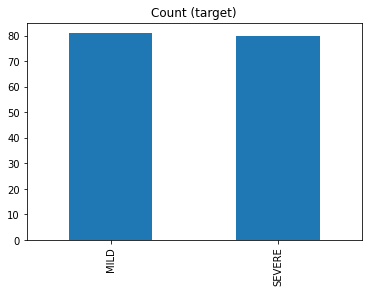

In [85]:
df = pd.DataFrame(X_sm_ADA, columns=features)
df['target'] = y_sm_ADA

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [86]:
feat_selector.fit(np.array(X_sm_ADA), y_sm_ADA)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	546
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	115
Rejected: 	431
Iteration: 	9 / 100
Confirmed: 	30
Tentative: 	85
Rejected: 	431
Iteration: 	10 / 100
Confirmed: 	30
Tentative: 	85
Rejected: 	431
Iteration: 	11 / 100
Confirmed: 	30
Tentative: 	85
Rejected: 	431
Iteration: 	12 / 100
Confirmed: 	43
Tentative: 	72
Rejected: 	431
Iteration: 	13 / 100
Confirmed: 	43
Tentative: 	72
Rejected: 	431
Iteration: 	14 / 100
Confirmed: 	43
Tentative: 	72
Rejected: 	431
Iteration: 	15 / 100
Confirmed: 	43
Tentative: 	72
Rejected: 	431
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=277, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2B096C88240),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B096C88240, verbose=2)

In [87]:
print("Number of selected features: ", feat_selector.n_features_)

Number of selected features:  67


In [88]:
# Best Features (accord to Boruta)
X_sm_ADA.columns[feat_selector.support_]

Index(['Freq.1261.3335177338', 'Freq.1324.07107187346',
       'Freq.1399.46591504505', 'Freq.1477.70491383112',
       'Freq.1522.99914751846', 'Freq.1571.40357692951',
       'Freq.1649.08923599114', 'Freq.1715.83254187774',
       'Freq.1740.12061901788', 'Freq.1794.21713030157',
       'Freq.1987.25255033859', 'Freq.2032.98713905056',
       'Freq.2052.46119506721', 'Freq.2100.44990262345',
       'Freq.2147.21242083795', 'Freq.2182.54012190969',
       'Freq.2187.26929655148', 'Freq.2224.44106274883',
       'Freq.2241.01398322552', 'Freq.2245.38681433931',
       'Freq.2382.42710415359', 'Freq.2433.47999073313',
       'Freq.2439.77083354138', 'Freq.2461.57721259156',
       'Freq.2499.61668472587', 'Freq.2528.65319900938',
       'Freq.2540.60771257846', 'Freq.2552.55336332551',
       'Freq.2688.58622661988', 'Freq.2822.17822957638',
       'Freq.2981.05105455515', 'Freq.3044.22068852996',
       'Freq.3083.87231952593', 'Freq.3275.14240190952',
       'Freq.3345.67126398784', 

In [89]:
# Filter most importante features
X_transform_ADA = feat_selector.transform(np.array(X_sm_ADA))

In [90]:
# Define objectiva funtion to maximize metric
def objective(trial):
    
    # List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])
    # Define scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = Pipeline([("scaler", scaler),
                    ("lgbm_clf", lgb.LGBMClassifier(random_state=SEED, **param))])
    # Get CV Metric we want to maximize
    balanced_accuracy = np.mean(cross_val_score(clf, X_transform_ADA, y_sm_ADA, scoring=metric_scorer, cv=rkf, n_jobs=-1))
    
    return balanced_accuracy

In [91]:
study = optuna.create_study(direction="maximize")

[I 2022-06-29 20:36:41,977] A new study created in memory with name: no-name-1bd67824-029d-4ad4-b21c-e793224d571a


In [92]:
study.optimize(objective, n_trials=500)

[I 2022-06-29 20:36:45,915] Trial 0 finished with value: 0.5 and parameters: {'scalers': 'robust', 'lambda_l1': 2.3322150671343342e-08, 'lambda_l2': 0.5343269967391384, 'num_leaves': 27, 'feature_fraction': 0.8457020493849466, 'bagging_fraction': 0.6607728625164124, 'bagging_freq': 2, 'min_child_samples': 70, 'max_depth': 412}. Best is trial 0 with value: 0.5.
[I 2022-06-29 20:36:47,753] Trial 1 finished with value: 0.9283325870465963 and parameters: {'scalers': 'standard', 'lambda_l1': 0.11028036858299374, 'lambda_l2': 0.0016532585962470642, 'num_leaves': 254, 'feature_fraction': 0.6138996350165489, 'bagging_fraction': 0.8446680925350405, 'bagging_freq': 3, 'min_child_samples': 53, 'max_depth': 605}. Best is trial 1 with value: 0.9283325870465963.
[I 2022-06-29 20:36:48,091] Trial 2 finished with value: 0.5 and parameters: {'scalers': 'minmax', 'lambda_l1': 7.109455442641812e-08, 'lambda_l2': 0.00141182466184893, 'num_leaves': 128, 'feature_fraction': 0.8837437670592151, 'bagging_frac

[I 2022-06-29 20:37:18,519] Trial 21 finished with value: 0.9372680371099489 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0017458077327557487, 'lambda_l2': 1.6247644525536437e-07, 'num_leaves': 146, 'feature_fraction': 0.5588063064121827, 'bagging_fraction': 0.5922332720616372, 'bagging_freq': 4, 'min_child_samples': 34, 'max_depth': 895}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:37:19,596] Trial 22 finished with value: 0.8681126408206516 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0004817580773317378, 'lambda_l2': 4.247298487529281e-06, 'num_leaves': 193, 'feature_fraction': 0.5565324547355336, 'bagging_fraction': 0.4566726069029934, 'bagging_freq': 4, 'min_child_samples': 35, 'max_depth': 878}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:37:21,496] Trial 23 finished with value: 0.9335635667651924 and parameters: {'scalers': 'standard', 'lambda_l1': 4.337325391139686e-05, 'lambda_l2': 1.8317316798107736e-07, 'num_leav

[I 2022-06-29 20:37:46,823] Trial 41 finished with value: 0.8457184594731035 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.00077515047493139, 'lambda_l2': 1.540716505270771e-06, 'num_leaves': 139, 'feature_fraction': 0.6850262908955553, 'bagging_fraction': 0.5270633832952701, 'bagging_freq': 4, 'min_child_samples': 40, 'max_depth': 776}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:37:47,971] Trial 42 finished with value: 0.7136915684504694 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0030566820166468165, 'lambda_l2': 2.190732334178046e-05, 'num_leaves': 164, 'feature_fraction': 0.8239188553151514, 'bagging_fraction': 0.5870089269053006, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 831}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:37:50,201] Trial 43 finished with value: 0.9295374473737477 and parameters: {'scalers': 'minmax', 'lambda_l1': 0.001013101900587424, 'lambda_l2': 2.7228301809427013e-06, 'num_leaves': 153, 

[I 2022-06-29 20:38:23,872] Trial 62 finished with value: 0.9377535674250069 and parameters: {'scalers': 'standard', 'lambda_l1': 0.00036265485146514103, 'lambda_l2': 2.624180997120856e-07, 'num_leaves': 185, 'feature_fraction': 0.7710049046529849, 'bagging_fraction': 0.5345110934223039, 'bagging_freq': 5, 'min_child_samples': 29, 'max_depth': 970}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:38:25,997] Trial 63 finished with value: 0.9338245198643804 and parameters: {'scalers': 'standard', 'lambda_l1': 0.00028693225777101693, 'lambda_l2': 3.964147445786139e-07, 'num_leaves': 188, 'feature_fraction': 0.7668375774507401, 'bagging_fraction': 0.5253568124049548, 'bagging_freq': 6, 'min_child_samples': 28, 'max_depth': 978}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:38:28,121] Trial 64 finished with value: 0.931133630795589 and parameters: {'scalers': 'standard', 'lambda_l1': 2.502875463585129e-05, 'lambda_l2': 2.4201106169901e-08, 'num_leaves'

[I 2022-06-29 20:38:58,702] Trial 82 finished with value: 0.9360596896009048 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0008979547405199374, 'lambda_l2': 6.230431468776516e-06, 'num_leaves': 144, 'feature_fraction': 0.5773699933689849, 'bagging_fraction': 0.6319078355387133, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 915}. Best is trial 18 with value: 0.9393890862104871.
[I 2022-06-29 20:39:00,517] Trial 83 finished with value: 0.9395163067281876 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0003870926243952058, 'lambda_l2': 1.683258185654128e-05, 'num_leaves': 131, 'feature_fraction': 0.46714461674279795, 'bagging_fraction': 0.6062406206734199, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 941}. Best is trial 83 with value: 0.9395163067281876.
[I 2022-06-29 20:39:02,214] Trial 84 finished with value: 0.9424398196832408 and parameters: {'scalers': 'standard', 'lambda_l1': 0.00013969130399092063, 'lambda_l2': 1.899361581479506e-05, 'num_leav

[I 2022-06-29 20:39:29,931] Trial 102 finished with value: 0.936945157289391 and parameters: {'scalers': 'standard', 'lambda_l1': 4.9473191927689437e-08, 'lambda_l2': 4.263093762238697e-08, 'num_leaves': 59, 'feature_fraction': 0.4721782267030783, 'bagging_fraction': 0.5750857221080219, 'bagging_freq': 1, 'min_child_samples': 34, 'max_depth': 933}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:39:31,459] Trial 103 finished with value: 0.9395175971903913 and parameters: {'scalers': 'standard', 'lambda_l1': 1.3136192598709008e-07, 'lambda_l2': 7.887238276534332e-08, 'num_leaves': 28, 'feature_fraction': 0.49641956672360404, 'bagging_fraction': 0.6067424453991461, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 999}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:39:32,831] Trial 104 finished with value: 0.9359100267637419 and parameters: {'scalers': 'standard', 'lambda_l1': 9.818720569794156e-08, 'lambda_l2': 7.699855876041722e-08, 'num_lea

[I 2022-06-29 20:39:58,002] Trial 122 finished with value: 0.9410076445312514 and parameters: {'scalers': 'standard', 'lambda_l1': 1.55402365158768e-08, 'lambda_l2': 1.1515431327188794e-08, 'num_leaves': 80, 'feature_fraction': 0.5017608224468145, 'bagging_fraction': 0.6284536124192103, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 922}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:39:59,679] Trial 123 finished with value: 0.9355292523309164 and parameters: {'scalers': 'standard', 'lambda_l1': 1.832293050722724e-08, 'lambda_l2': 1.1819701190751146e-08, 'num_leaves': 100, 'feature_fraction': 0.5290588792318207, 'bagging_fraction': 0.6260313825377354, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 921}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:40:01,347] Trial 124 finished with value: 0.9377881351964169 and parameters: {'scalers': 'standard', 'lambda_l1': 4.837798375316271e-08, 'lambda_l2': 2.8489459192579742e-08, 'num_le

[I 2022-06-29 20:40:35,635] Trial 142 finished with value: 0.938255026642604 and parameters: {'scalers': 'standard', 'lambda_l1': 1.9257720670364635e-08, 'lambda_l2': 4.403835165478485e-08, 'num_leaves': 95, 'feature_fraction': 0.5053353323652063, 'bagging_fraction': 0.5678744562543485, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 979}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:40:37,312] Trial 143 finished with value: 0.8164056885022443 and parameters: {'scalers': 'standard', 'lambda_l1': 7.05079481776767, 'lambda_l2': 6.409551264407939e-08, 'num_leaves': 89, 'feature_fraction': 0.5225118928939597, 'bagging_fraction': 0.5998453544170024, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 956}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:40:39,190] Trial 144 finished with value: 0.9352885713143065 and parameters: {'scalers': 'standard', 'lambda_l1': 4.3206805341843266e-08, 'lambda_l2': 2.978180410108786e-08, 'num_leaves': 

[I 2022-06-29 20:41:10,707] Trial 162 finished with value: 0.9399735735111122 and parameters: {'scalers': 'standard', 'lambda_l1': 3.106850294456042e-08, 'lambda_l2': 2.3208465540934213e-08, 'num_leaves': 98, 'feature_fraction': 0.46942107524882876, 'bagging_fraction': 0.5620642160202195, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 875}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:41:12,500] Trial 163 finished with value: 0.9405048703446536 and parameters: {'scalers': 'standard', 'lambda_l1': 4.859020757323469e-08, 'lambda_l2': 3.567315794025674e-08, 'num_leaves': 97, 'feature_fraction': 0.4903598814458423, 'bagging_fraction': 0.5463801693325754, 'bagging_freq': 2, 'min_child_samples': 26, 'max_depth': 874}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:41:14,377] Trial 164 finished with value: 0.8987126140543323 and parameters: {'scalers': 'standard', 'lambda_l1': 3.1378940470031685e-07, 'lambda_l2': 5.005482309439676e-08, 'num_le

[I 2022-06-29 20:41:44,592] Trial 182 finished with value: 0.9375275138518171 and parameters: {'scalers': 'standard', 'lambda_l1': 2.7944826246292323e-08, 'lambda_l2': 1.5563233305228756e-08, 'num_leaves': 80, 'feature_fraction': 0.5850701268973738, 'bagging_fraction': 0.6046591420570387, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 907}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:41:46,580] Trial 183 finished with value: 0.9416780157192309 and parameters: {'scalers': 'standard', 'lambda_l1': 4.4475919915514785e-08, 'lambda_l2': 2.147555042937926e-08, 'num_leaves': 97, 'feature_fraction': 0.520230062156154, 'bagging_fraction': 0.5909945754441146, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 1000}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:41:48,574] Trial 184 finished with value: 0.9367398083083067 and parameters: {'scalers': 'standard', 'lambda_l1': 6.172207296970486e-08, 'lambda_l2': 2.1630386736149088e-08, 'num_l

[I 2022-06-29 20:42:23,288] Trial 202 finished with value: 0.9385425791528732 and parameters: {'scalers': 'standard', 'lambda_l1': 3.6311479322887722e-06, 'lambda_l2': 2.102613570396642e-08, 'num_leaves': 100, 'feature_fraction': 0.501348351288236, 'bagging_fraction': 0.6116106568143056, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 961}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:42:25,270] Trial 203 finished with value: 0.9398001520538286 and parameters: {'scalers': 'standard', 'lambda_l1': 3.990800864876031e-07, 'lambda_l2': 5.723036183523343e-08, 'num_leaves': 94, 'feature_fraction': 0.4932657773574819, 'bagging_fraction': 0.579732413599723, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 979}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:42:27,184] Trial 204 finished with value: 0.9396341816937792 and parameters: {'scalers': 'standard', 'lambda_l1': 6.152301077891933e-07, 'lambda_l2': 6.06116698301059e-08, 'num_leaves

[I 2022-06-29 20:43:03,677] Trial 222 finished with value: 0.9409783375379351 and parameters: {'scalers': 'standard', 'lambda_l1': 1.583141776761031e-08, 'lambda_l2': 1.0107098468131961e-08, 'num_leaves': 109, 'feature_fraction': 0.5079910977246833, 'bagging_fraction': 0.598891163285849, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 978}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:43:05,686] Trial 223 finished with value: 0.9385458550951973 and parameters: {'scalers': 'standard', 'lambda_l1': 1.04930780633418e-08, 'lambda_l2': 0.00012863202421901237, 'num_leaves': 111, 'feature_fraction': 0.5187303721935375, 'bagging_fraction': 0.6199731950590415, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 970}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:43:07,734] Trial 224 finished with value: 0.9399010085202038 and parameters: {'scalers': 'standard', 'lambda_l1': 4.3408339890482574e-08, 'lambda_l2': 1.5216099208065885e-08, 'num_l

[I 2022-06-29 20:43:42,902] Trial 242 finished with value: 0.9403263921750764 and parameters: {'scalers': 'standard', 'lambda_l1': 1.005484893090887e-08, 'lambda_l2': 2.2262087816648392e-08, 'num_leaves': 77, 'feature_fraction': 0.5303107536990883, 'bagging_fraction': 0.595200056428936, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 962}. Best is trial 84 with value: 0.9424398196832408.
[I 2022-06-29 20:43:44,799] Trial 243 finished with value: 0.9429037205699359 and parameters: {'scalers': 'standard', 'lambda_l1': 1.1038169233095588e-08, 'lambda_l2': 3.030128060578721e-08, 'num_leaves': 77, 'feature_fraction': 0.5458191676105331, 'bagging_fraction': 0.5977920353008292, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 919}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:43:46,798] Trial 244 finished with value: 0.93956040936188 and parameters: {'scalers': 'standard', 'lambda_l1': 1.1108067586465253e-08, 'lambda_l2': 2.3813293886899503e-08, 'num_lea

[I 2022-06-29 20:44:18,865] Trial 262 finished with value: 0.938779339232319 and parameters: {'scalers': 'standard', 'lambda_l1': 1.0293747083032818e-08, 'lambda_l2': 1.4240452837067526e-08, 'num_leaves': 62, 'feature_fraction': 0.5457031129234, 'bagging_fraction': 0.6135570224045442, 'bagging_freq': 2, 'min_child_samples': 38, 'max_depth': 916}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:44:20,853] Trial 263 finished with value: 0.9391039181621612 and parameters: {'scalers': 'standard', 'lambda_l1': 2.626375051777939e-08, 'lambda_l2': 2.6032437776563576e-08, 'num_leaves': 84, 'feature_fraction': 0.5707397132978659, 'bagging_fraction': 0.6258436494582719, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 922}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:44:21,681] Trial 264 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 2.1210608371085734e-08, 'lambda_l2': 1.9723935786276115e-08, 'num_leaves': 56, 'fea

[I 2022-06-29 20:44:54,085] Trial 282 finished with value: 0.9269084331990678 and parameters: {'scalers': 'standard', 'lambda_l1': 0.31346038997262154, 'lambda_l2': 2.2972349010402975e-08, 'num_leaves': 66, 'feature_fraction': 0.535123428762721, 'bagging_fraction': 0.6150375570120534, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 952}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:44:55,986] Trial 283 finished with value: 0.939061647202127 and parameters: {'scalers': 'standard', 'lambda_l1': 5.5358206949148855e-08, 'lambda_l2': 3.2467653593706504e-08, 'num_leaves': 82, 'feature_fraction': 0.5503700551435121, 'bagging_fraction': 0.5951377295645515, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 909}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:44:56,515] Trial 284 finished with value: 0.5 and parameters: {'scalers': 'standard', 'lambda_l1': 3.851150633126088e-08, 'lambda_l2': 1.3996631567108038e-08, 'num_leaves': 60, 'feat

[I 2022-06-29 20:45:28,010] Trial 302 finished with value: 0.9382531061774482 and parameters: {'scalers': 'standard', 'lambda_l1': 1.996140581275144e-08, 'lambda_l2': 3.7286309575849555e-08, 'num_leaves': 71, 'feature_fraction': 0.5034674691126452, 'bagging_fraction': 0.5822270219187509, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 955}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:45:30,056] Trial 303 finished with value: 0.9368663873106597 and parameters: {'scalers': 'standard', 'lambda_l1': 4.407694837562482e-08, 'lambda_l2': 1.8888118027569405e-08, 'num_leaves': 77, 'feature_fraction': 0.5623533409769058, 'bagging_fraction': 0.7318550663920224, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 939}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:45:31,891] Trial 304 finished with value: 0.9060627672765831 and parameters: {'scalers': 'standard', 'lambda_l1': 0.8474038570855622, 'lambda_l2': 3.021496545194755e-08, 'num_leav

[I 2022-06-29 20:46:02,465] Trial 322 finished with value: 0.9335534110712129 and parameters: {'scalers': 'standard', 'lambda_l1': 2.6481989033354088e-08, 'lambda_l2': 0.15036777814486257, 'num_leaves': 88, 'feature_fraction': 0.539227055355546, 'bagging_fraction': 0.5725831345527603, 'bagging_freq': 2, 'min_child_samples': 24, 'max_depth': 880}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:46:04,192] Trial 323 finished with value: 0.9367327202166598 and parameters: {'scalers': 'standard', 'lambda_l1': 1.7507522209789435e-08, 'lambda_l2': 0.0005403180906235681, 'num_leaves': 82, 'feature_fraction': 0.5691729944956323, 'bagging_fraction': 0.6099338836421156, 'bagging_freq': 2, 'min_child_samples': 28, 'max_depth': 860}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:46:06,193] Trial 324 finished with value: 0.9161250493357691 and parameters: {'scalers': 'standard', 'lambda_l1': 7.671565403191199e-08, 'lambda_l2': 7.915467469958266, 'num_leaves':

[I 2022-06-29 20:46:36,312] Trial 342 finished with value: 0.9414202108091427 and parameters: {'scalers': 'standard', 'lambda_l1': 1.0224327499367452e-07, 'lambda_l2': 1.0621018869068173e-07, 'num_leaves': 93, 'feature_fraction': 0.5900889740149244, 'bagging_fraction': 0.597009323279011, 'bagging_freq': 2, 'min_child_samples': 33, 'max_depth': 980}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:46:38,053] Trial 343 finished with value: 0.9357267229459566 and parameters: {'scalers': 'standard', 'lambda_l1': 6.886806038707954e-08, 'lambda_l2': 7.619803180096809e-08, 'num_leaves': 97, 'feature_fraction': 0.5887744200492779, 'bagging_fraction': 0.5659198452543461, 'bagging_freq': 2, 'min_child_samples': 34, 'max_depth': 977}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:46:39,087] Trial 344 finished with value: 0.9045319708456319 and parameters: {'scalers': 'standard', 'lambda_l1': 9.626579025042631e-08, 'lambda_l2': 4.6512430203001575e-08, 'num_l

[I 2022-06-29 20:47:07,071] Trial 362 finished with value: 0.9326402697749446 and parameters: {'scalers': 'standard', 'lambda_l1': 0.05952847223023421, 'lambda_l2': 1.4405446058695599e-08, 'num_leaves': 77, 'feature_fraction': 0.48930644190358713, 'bagging_fraction': 0.5725889987445705, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 556}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:47:08,441] Trial 363 finished with value: 0.936663316172991 and parameters: {'scalers': 'standard', 'lambda_l1': 5.893649713371182e-08, 'lambda_l2': 2.2490709763867324e-08, 'num_leaves': 87, 'feature_fraction': 0.5456473717937528, 'bagging_fraction': 0.6245906318393724, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 682}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:47:10,957] Trial 364 finished with value: 0.9281293512773776 and parameters: {'scalers': 'standard', 'lambda_l1': 1.4238962459830368e-08, 'lambda_l2': 3.9054132992142465e-08, 'num_l

[I 2022-06-29 20:47:51,538] Trial 382 finished with value: 0.9390834549437491 and parameters: {'scalers': 'standard', 'lambda_l1': 1.4502897896752867e-07, 'lambda_l2': 1.072350386399828e-07, 'num_leaves': 103, 'feature_fraction': 0.5418368345840063, 'bagging_fraction': 0.6001400649017983, 'bagging_freq': 2, 'min_child_samples': 30, 'max_depth': 908}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:47:53,508] Trial 383 finished with value: 0.9388733260203849 and parameters: {'scalers': 'standard', 'lambda_l1': 1.7565141498845895e-07, 'lambda_l2': 1.4185330549821866e-08, 'num_leaves': 100, 'feature_fraction': 0.5727124856500067, 'bagging_fraction': 0.6296799566066035, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 922}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:47:55,635] Trial 384 finished with value: 0.939786009849284 and parameters: {'scalers': 'minmax', 'lambda_l1': 2.041753725605397e-07, 'lambda_l2': 7.72268856130085e-06, 'num_le

[I 2022-06-29 20:48:25,882] Trial 402 finished with value: 0.9374185274649672 and parameters: {'scalers': 'robust', 'lambda_l1': 0.00014110808673698964, 'lambda_l2': 9.282863245969053e-08, 'num_leaves': 88, 'feature_fraction': 0.7299956404674717, 'bagging_fraction': 0.6451559279373387, 'bagging_freq': 3, 'min_child_samples': 31, 'max_depth': 838}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:48:27,670] Trial 403 finished with value: 0.9373053588568295 and parameters: {'scalers': 'robust', 'lambda_l1': 0.0004847291598811719, 'lambda_l2': 2.283590274033305e-07, 'num_leaves': 106, 'feature_fraction': 0.7075994086728589, 'bagging_fraction': 0.6231267073881974, 'bagging_freq': 4, 'min_child_samples': 38, 'max_depth': 860}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:48:29,568] Trial 404 finished with value: 0.936942517363957 and parameters: {'scalers': 'robust', 'lambda_l1': 4.244962664421973e-06, 'lambda_l2': 1.3118225146861294e-05, 'num_leaves'

[I 2022-06-29 20:49:02,739] Trial 422 finished with value: 0.9326035236263565 and parameters: {'scalers': 'standard', 'lambda_l1': 0.0023926260944552723, 'lambda_l2': 7.531336072576421e-08, 'num_leaves': 85, 'feature_fraction': 0.5716673228977308, 'bagging_fraction': 0.6247493540151938, 'bagging_freq': 2, 'min_child_samples': 36, 'max_depth': 625}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:49:04,479] Trial 423 finished with value: 0.9354963211023584 and parameters: {'scalers': 'standard', 'lambda_l1': 2.0734158749866026e-08, 'lambda_l2': 1.9879041563816816e-08, 'num_leaves': 97, 'feature_fraction': 0.6101720070080846, 'bagging_fraction': 0.6481591620510254, 'bagging_freq': 2, 'min_child_samples': 29, 'max_depth': 906}. Best is trial 243 with value: 0.9429037205699359.
[I 2022-06-29 20:49:06,132] Trial 424 finished with value: 0.9387547547481756 and parameters: {'scalers': 'standard', 'lambda_l1': 3.3958557856216857e-08, 'lambda_l2': 3.4906752214847415e-08, 'num

[I 2022-06-29 20:49:37,984] Trial 442 finished with value: 0.9367783723844094 and parameters: {'scalers': 'robust', 'lambda_l1': 3.1911866847585344e-05, 'lambda_l2': 3.130748276078324e-07, 'num_leaves': 115, 'feature_fraction': 0.43948634370368433, 'bagging_fraction': 0.49730793534030027, 'bagging_freq': 3, 'min_child_samples': 24, 'max_depth': 863}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:49:39,733] Trial 443 finished with value: 0.9365187143437917 and parameters: {'scalers': 'robust', 'lambda_l1': 1.3265451096231846e-05, 'lambda_l2': 1.4017631429600757e-07, 'num_leaves': 117, 'feature_fraction': 0.4393512252926389, 'bagging_fraction': 0.5323001986308528, 'bagging_freq': 2, 'min_child_samples': 25, 'max_depth': 826}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:49:41,524] Trial 444 finished with value: 0.9381891611355619 and parameters: {'scalers': 'robust', 'lambda_l1': 6.255310101917651e-05, 'lambda_l2': 1.6378382546086169e-07, 'num_l

[I 2022-06-29 20:50:13,978] Trial 462 finished with value: 0.9377948342721949 and parameters: {'scalers': 'robust', 'lambda_l1': 0.00018715733186227344, 'lambda_l2': 6.554681568073484e-05, 'num_leaves': 104, 'feature_fraction': 0.49514455450695793, 'bagging_fraction': 0.5441776114756938, 'bagging_freq': 2, 'min_child_samples': 27, 'max_depth': 863}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:50:15,795] Trial 463 finished with value: 0.9374302498971617 and parameters: {'scalers': 'robust', 'lambda_l1': 4.033595621418409e-06, 'lambda_l2': 1.830793691498165e-07, 'num_leaves': 108, 'feature_fraction': 0.4137587899257104, 'bagging_fraction': 0.5642414975415834, 'bagging_freq': 2, 'min_child_samples': 31, 'max_depth': 877}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:50:17,688] Trial 464 finished with value: 0.9346748080565805 and parameters: {'scalers': 'robust', 'lambda_l1': 2.8142406098305028e-05, 'lambda_l2': 7.24091426514438e-08, 'num_leave

[I 2022-06-29 20:50:50,793] Trial 482 finished with value: 0.9395092824916741 and parameters: {'scalers': 'robust', 'lambda_l1': 4.771650511692516e-05, 'lambda_l2': 6.360407005191209e-07, 'num_leaves': 75, 'feature_fraction': 0.43361403284121597, 'bagging_fraction': 0.6720555733861501, 'bagging_freq': 1, 'min_child_samples': 35, 'max_depth': 972}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:50:52,671] Trial 483 finished with value: 0.9392667397961516 and parameters: {'scalers': 'robust', 'lambda_l1': 6.322983181847536e-05, 'lambda_l2': 3.8982800139585883e-07, 'num_leaves': 82, 'feature_fraction': 0.41942729987586197, 'bagging_fraction': 0.6401030803175156, 'bagging_freq': 1, 'min_child_samples': 32, 'max_depth': 966}. Best is trial 436 with value: 0.9434452754203142.
[I 2022-06-29 20:50:54,512] Trial 484 finished with value: 0.9409574759390936 and parameters: {'scalers': 'robust', 'lambda_l1': 1.8881448228362237e-05, 'lambda_l2': 1.0042178830150446e-06, 'num_leav

In [93]:
# Get best trial based on metric score
trial = study.best_trial

In [94]:
# Print params for best trial
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    scalers: robust
    lambda_l1: 7.309657353794317e-06
    lambda_l2: 2.2412401926672247e-08
    num_leaves: 101
    feature_fraction: 0.4692447108760777
    bagging_fraction: 0.5874897698694822
    bagging_freq: 2
    min_child_samples: 29
    max_depth: 905


In [95]:
# Best Score from HP Opt
trial.values[0]

0.9434452754203142

In [96]:
gbm_opt = lgb.LGBMClassifier(random_state=SEED, **trial.params)

In [97]:
X_transform_test = feat_selector.transform(np.array(X_test))

In [98]:
X_transform_test.shape

(64, 67)

In [101]:
gbm_opt.fit(X_transform_ADA,y_sm_ADA)

LGBMClassifier(bagging_fraction=0.5874897698694822, bagging_freq=2,
               feature_fraction=0.4692447108760777,
               lambda_l1=7.309657353794317e-06,
               lambda_l2=2.2412401926672247e-08, max_depth=905,
               min_child_samples=29, num_leaves=101, random_state=42,
               scalers='robust')

In [102]:
y_pred = gbm_opt.predict(X_transform_test)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        MILD       0.70      0.67      0.68        42
      SEVERE       0.42      0.45      0.43        22

    accuracy                           0.59        64
   macro avg       0.56      0.56      0.56        64
weighted avg       0.60      0.59      0.60        64



* SMOTE ADA não obteve um bom score